In [1]:
import os
import sys
sys.path.append('/home/kevinteng/Desktop/DE_Project')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from coord_conv import CoordConv
import cv2
import utils
import utils_vis
import utils_model
from sklearn.model_selection import train_test_split
from utils_vis import plot_comparison
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
from random import randint, seed
from utils import stack4plot, similarity_multi, similarity_multiplication
from utils_vis import overlapMasks, overlapMasks02

/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-package

---------------------

# Retrieving and Preprocess Data

Image size:  100


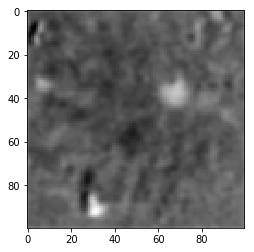

In [2]:
dataset = np.load('/home/kevinteng/Desktop/jpg_to_npy_benchmark/DG13_3-8-17_preprocessed_dF.npy')

#hyperparameter 
NEW_SIZE = 100
ver = '18' #version no.
BATCH_SIZE = 8
lr01 = 0.00001
lr02 = 0.000001
n_neurons = 200
MAX_EPOCHS = 2000
l1_coeff = 0.1
path_desktop = '/home/kevinteng/Desktop/'
#re_list = dataset
re_list = utils.resize(dataset, NEW_SIZE)
IMG_SIZE = re_list.shape[1]

print('Image size: ', IMG_SIZE)
#Dimension for network should include the color channel 
re_list = np.expand_dims(re_list, axis = -1)
#Cast data type to float32 for TensorFlow
# re_list = re_list.astype('float32')
re_list = tf.convert_to_tensor(re_list, dtype = tf.float32)

for img in re_list:
    plt.imshow(np.reshape(img, (IMG_SIZE, IMG_SIZE)), cmap = 'gray')
    plt.show()
    
    break
    
#     if input()=='exit':
#         break

In [3]:
#apply min max norm for mean image
re_list = utils.min_max_norm(re_list)
#max_img_ori = np.expand_dims(max_img_ori, -1)
print('Max value:', np.max(re_list))
print('Min value:', np.min(re_list))


Max value: 1.0
Min value: 0.0


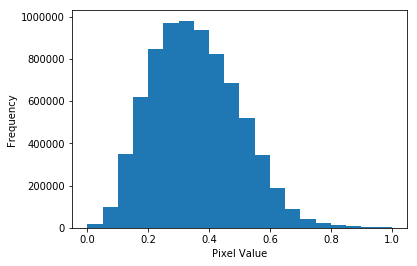

In [4]:
#plot historgram for min max norm image
plt.hist(tf.reshape(re_list, [-1]),20,[0,1])
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

----------------------------------------------------------


# Validation

In [5]:
coords,_, ori_one_hot_imgs = utils_model.create_dat_samples(n_neurons, IMG_SIZE, min_range = 5, 
                                                            max_range = 95, Range = True)
#normalizing 
# coords /= (IMG_SIZE-1)
coords = tf.reshape(coords, [n_neurons, 1,1,2])
tf.print(tf.shape(coords))

[200 1 1 2]


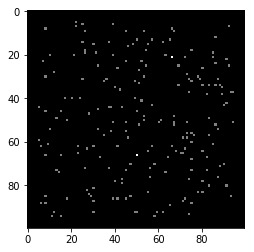

In [6]:
plt.imshow(np.squeeze(np.sum(ori_one_hot_imgs, axis=0)), cmap = 'gray')

-----------------------------------

# Model

In [7]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import InputLayer, Conv2DTranspose, Activation, BatchNormalization
from tensorflow.keras.layers import Input, Softmax
from tensorflow.keras.regularizers import l1
from utils_model import conv_block, coordconv_block, up_block, up_coord_block
from tensorflow.keras import layers


def encoder(inps, img_size):
    #downsampling
    coord01 =CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                       filters = 128,strides=(1,1), kernel_size = 3, padding='same'
                       ,activity_regularizer=l1(l1_coeff))(inps)
    act01=tf.keras.layers.ReLU()(coord01)
    pool01=MaxPooling2D((2, 2), strides=2,padding='same')(act01)
    conv01=Conv2D(64, kernel_size = 3, padding='same',activity_regularizer=l1(l1_coeff))(pool01)
    act02=tf.keras.layers.ReLU()(conv01)
    pool02=MaxPooling2D((2, 2), strides=2,padding='same')(act02)
    conv02=Conv2D(32, kernel_size = 3, padding='same',activity_regularizer=l1(l1_coeff))(pool02)
    act03=tf.keras.layers.ReLU()(conv02)
    pool03=MaxPooling2D((2, 2), strides=2,padding='same')(act03)
    
    #upsampling
    x=CoordConv(x_dim = 13, y_dim = 13, with_r = False, 
                filters = 128,strides=(1,1), kernel_size = 3, padding='same',
                activity_regularizer=l1(0.1))(pool03)
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(64, 3, padding = 'same', activation = 'relu',activity_regularizer=l1(l1_coeff))(x)
    x = UpSampling2D(size=(2,2))(x)
    x = Conv2D(32, 3, padding = 'valid', activation = 'relu',activity_regularizer=l1(l1_coeff))(x)
    x = UpSampling2D(size=(2,2))(x)
    x = Conv2D(16, 3, padding = 'same', activation = 'relu',activity_regularizer=l1(l1_coeff))(x)
    output = Conv2D(1, 3, padding = 'same', activation = 'sigmoid',activity_regularizer=l1(l1_coeff))(x)
    return output


def de_conv(input_tensor):
    coord01 = CoordConv(x_dim = 100, y_dim = 100, with_r = False, filters = 100,
              kernel_size = 1, padding='same', activation='relu')(input_tensor)
    conv01 = Conv2D(filters = 50, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(coord01)
    conv02 = Conv2D(filters = 50, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(conv01)
    conv03 = Conv2D(filters = 100, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(conv02)
    conv04 = Conv2D(filters = 100, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(conv03)
    conv05 = Conv2D(filters = 1, kernel_size = 1, strides = 1, padding = "same" )(conv04)
    f1 = Flatten()(conv05)
    output = Softmax(axis = -1)(f1)

    return output

def latent_space(encoded_imgs, deconv_imgs, coords, batch_size, img_size):
    '''
    This function construct the dot product of the output of an encoder(batch_size, img_size, img_size, 1) 
    with the one hot images generated by decoord-conv(n_neurons, img_size, img_size, 1), which yields
    similarity score (batch_size, n_neurons). Similarity score is then concatenate to the last layer of the 
    input coordinates with the corresponding batch (batch_size, n_neurons, 3)
    
    @encoded_imgs: output images from the encoder
    @deconv_imgs: one hot images generated from the coordinate list 
    @coords: A list of coordinates generated randomly based on the number of neurons
    @batch_size: Batch size of the input image for encoder, to allocate size for writing in loop
    
    return: 
        latent space with dim (batch_size, n_neurons, 3, 1)
    '''
    similarity_score = tf.tensordot(encoded_imgs, deconv_imgs, [[1,2,3],[1,2,3]]) #(batch_size, n_neurons)
#     squeeze_coords = tf.squeeze(coords/(img_size-1)) #coords dim (n_neurons, 1, 1, 2) = > (n_neurons, 2)
    squeeze_coords = tf.squeeze(coords)
    latent = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
    for i in tf.range(batch_size):
        concat = tf.stack((squeeze_coords[:,-2], squeeze_coords[:,-1], similarity_score[i]), axis=-1)    
        latent = latent.write(i, concat) #(batch_size, n_neurons, 3)
    return tf.expand_dims(latent.stack(), axis = -1), similarity_score

def duplicate_batch(inp_img, batch_size):
    '''
    This function duplicate an image with respect to its batch size
    @param inp_img: input image to be duplicated
    @param batch_size: batch size, which is the number of image to be duplicated

    return duplicated images along axis 0, (batch_size, img_size, img_size, 1)
    '''
    inp_img = tf.expand_dims(inp_img, 0)
    m2 = tf.constant([batch_size, 1, 1, 1], tf.int32)  # multiplier for tiling
    duplicate_imgs = tf.tile(inp_img, m2)
    return duplicate_imgs

def decoder(latent_dim):
    flat_01 = Flatten()(latent_dim)
    dense_01 = Dense(25*25*32, activation = 'relu')(flat_01)
    dense_01 = Reshape((25,25,32))(dense_01)
    up_01 = up_coord_block(dense_01, up_size = 2, x_dim = 50, y_dim = 50, filters = 64, 
                           kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')
    up_02 = up_block(up_01, up_size = 2, filters = 32, kernel_size = 3,
                            strides = 1, padding = 'same', activation = 'relu')
    output = Conv2D(filters = 1, kernel_size = 3, strides = 1,
                    padding = 'same', activation = None)(up_02)
    return output

class learnable_coords(layers.Layer):
    def __init__(self, coords):
        super(learnable_coords, self).__init__()
        self.learned_coords = tf.Variable((coords), trainable = True)

    def __call__(self, img_size):
        y = self.learned_coords/(img_size-1) #normalize the coordinates
    #         y = tf.clip_by_value(y, clip_value_min=0, clip_value_max=1) #clip values
        return y

In [8]:
# def encoder02(inps, img_size):
#     #1st block
#     coord01 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
#                         filters = 256, kernel_size = 3, padding='same')(inps)
#     leaky01 =tf.keras.layers.LeakyReLU(0.5)(coord01)
#     conv01 = Conv2D(filters = 128, kernel_size = 3, strides = 1, padding = "same", activation = 'relu')(leaky01 )
#     leaky02 = tf.keras.layers.LeakyReLU(0.5)(conv01)
#     output = Conv2D(1, kernel_size = 3,activation = 'linear', padding='same')(leaky02 )
#     return output

-----------------------------------------------------------------

## Build Model

In [9]:
#build encoder 
inps = Input(shape=(IMG_SIZE, IMG_SIZE, 1))
encoder_model = Model(inps, encoder(inps, IMG_SIZE))

#build coord model
inp = Input(shape=(100, 100,2)) #(batch_size, img_size, img_size, 2)
de_coordconv = Model(inp, de_conv(inp))
de_coordconv.load_weights("best_class_model100_02.hdf5")

#decoder
latent_dim = Input(shape=(n_neurons, 3, 1))
decoder_model = Model(latent_dim, decoder(latent_dim))

#learnable coords
l_coords = learnable_coords(coords)
# l_coords = tf.Variable((coords), trainable = True)

## Train Model

--------------------------------------

In [10]:
#optimizer 
opt_global = tf.keras.optimizers.Adam(lr01)
opt_encoded_onehot = tf.keras.optimizers.Adam(lr02)
opt_coords = tf.keras.optimizers.Adam(0.1)
#loss function 
mse = tf.losses.MeanSquaredError()
@tf.function
def train_fn(inp_imgs, coords, img_size, batch_size, neuron_multi = True, one_hot_thr = True):
    with tf.GradientTape(persistent=True) as tape:
        #--RHS pipeline (Learnable Coords)--
        #custom layer for updating coordinates
        updated_coords = l_coords(img_size)
        m1 = tf.constant([1,img_size,img_size,1], tf.int32) #multiplier for tiling 
        #tile coordinates (n_neurons, img_size, img_size, 1)
        tile_cd = tf.tile(updated_coords, m1)
        #de-coordconv model
        de_coordconv.trainable = False #freeze de-coordconv
        one_hot_imgs = tf.reshape(de_coordconv(tile_cd),[-1,img_size, img_size, 1]) #(n_neurons, img_size, img_size, 1)
        
        #--LHS pipeline (Encoder Pipeline)--
        #output from encoder (batch_size, img_size, img_size, 1)
        encoder_output = encoder_model(inp_imgs)
        
        #--Bottle Neck--
        #latent space
        latent, similarity_score = latent_space(encoder_output, one_hot_imgs, updated_coords, batch_size, img_size)#(batch_size, n_neurons, 3, 1)
        #compute the mse between the neurons with the one hot images generated by the deconv
        if not neuron_multi:
            #sum one hot images for all neurons, (n_neurons, img_size, img_size, 1) => (img_size, img_size, 1)
            one_hot_sum = tf.math.reduce_sum(one_hot_imgs, 0)
            #duplicate summed one_hot_images and compare with encoded output 
            #(img_size, img_size, 1) => (batch_size, img_size, img_size, 1) 
            duplicated_one_hot = duplicate_batch(one_hot_sum, batch_size)
            #loss between the encoded output and the one hot images 
            encoded_one_loss = mse(encoder_output, duplicated_one_hot)
        #compute the mse between the neurons with one hot images multiplied by similarity scores
        else:
            #multiply similarity scores with one hot images
            #(batch_size, n_neurons, img_size, img_size,1)
            similarity_multi = tf.einsum('ij,jklm->ijklm', similarity_score, one_hot_imgs) 
            #(batch_size, img_size, img_size, 1)
            similarity_multi_reduced_neurons = tf.reduce_sum(similarity_multi, axis=1)
            if one_hot_thr:
                #threshold multiplied similarity scores with one hot images
                similarity_multi_threshold = tf.where(similarity_multi_reduced_neurons<0.7, 0.0, similarity_multi_reduced_neurons)
                #loss between the encoded output and the one hot images 
                encoded_one_loss = mse(encoder_output, similarity_multi_threshold)
            else: 
                encoded_one_loss = mse(encoder_output, similarity_multi_reduced_neurons)
            
        #--Decoder--
        #reconstruction 
        reconstruction = decoder_model(latent)  
        #--Loss--
        #the loss that backprop through the whole pipeline 
        global_loss = mse(inp_imgs, reconstruction)
        #regularizer loss
        regularizer_loss = tf.math.reduce_sum(encoder_model.losses)
        #append loss 
        loss = [global_loss, encoded_one_loss, regularizer_loss]
    
    #back prop through encoder + decoder + learnable_coords
    varis_global = encoder_model.trainable_variables + decoder_model.trainable_variables + l_coords.trainable_variables
    grad_model = tape.gradient(global_loss, varis_global)
    opt_global.apply_gradients(zip(grad_model, varis_global))
    
    #back prop through encoder + learnable_coords
    varis_encoded_one = encoder_model.trainable_variables
    grad_partial = tape.gradient(encoded_one_loss, varis_encoded_one)
    opt_encoded_onehot.apply_gradients(zip(grad_partial, varis_encoded_one))
    #mapping from continuous to discrete pixel space
    scale = int(10/lr02) #empirical scale
    grad_coords = tape.gradient(encoded_one_loss, l_coords.trainable_variables)
#     grad_coords = scale*grad_coords
    opt_coords.apply_gradients(zip(grad_coords, l_coords.trainable_variables))
    
    grad = [grad_model, grad_partial]
    return loss, updated_coords, one_hot_imgs, encoder_output, similarity_score, reconstruction, grad

In [11]:
# ds_dir = '/home/kevinteng/Desktop/jpg_to_npy_benchmark/'

# for d in sorted(os.listdir(ds_dir)):
#     merge_d = os.path.join(ds_dir+d)
#     imgs = dataset_parse(merge_d, 100)
#     break

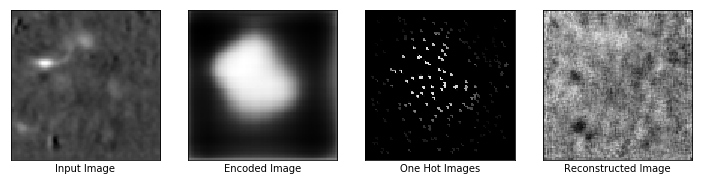

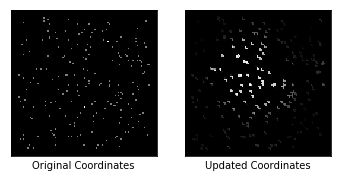

Epochs: 10, Reconstruction Loss: 0.005377146881073713
Regularizer Loss: 24319.26953125, Total Loss: 24319.275390625
Similarity Loss: 0.3988468647003174
Max Similarity scores: 0.9079372882843018
Updated Coordinates: [[[0.5188911  0.27053893]]]
Gradient global min:-0.0013022348284721375, max:0.0013019924517720938
Gradient partial min:-0.1375173032283783, max:0.23636558651924133



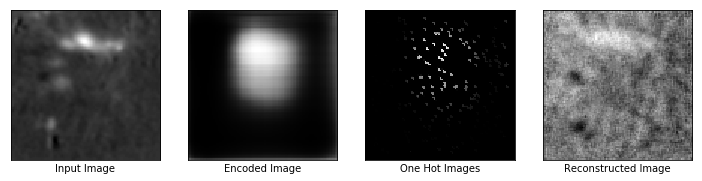

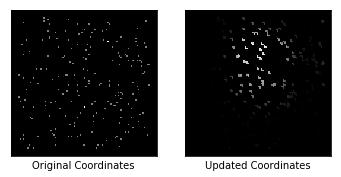

Epochs: 20, Reconstruction Loss: 0.004166369792073965
Regularizer Loss: 26735.07421875, Total Loss: 26735.078125
Similarity Loss: 0.33106714487075806
Max Similarity scores: 0.896757960319519
Updated Coordinates: [[[0.5189303  0.27049288]]]
Gradient global min:-0.0005504192668013275, max:0.0005067711463198066
Gradient partial min:-0.1346847265958786, max:0.228239044547081



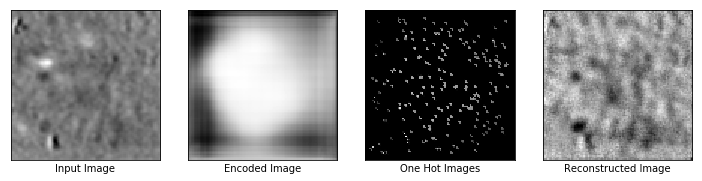

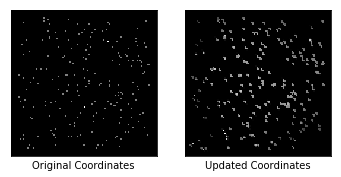

Epochs: 30, Reconstruction Loss: 0.0038153401110321283
Regularizer Loss: 27445.7578125, Total Loss: 27445.76171875
Similarity Loss: 0.3104967772960663
Max Similarity scores: 0.9314202666282654
Updated Coordinates: [[[0.5189362  0.27051833]]]
Gradient global min:-0.0006101691978983581, max:0.00048465459258295596
Gradient partial min:-0.1277572512626648, max:0.21442419290542603



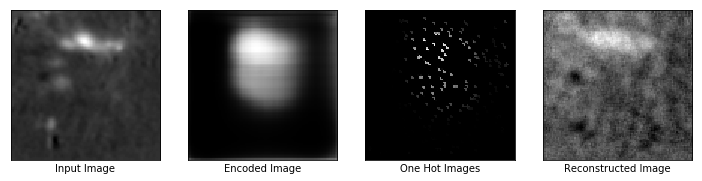

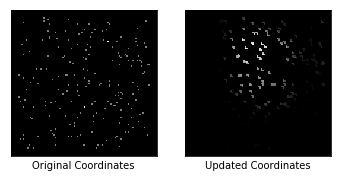

Epochs: 40, Reconstruction Loss: 0.003590372856706381
Regularizer Loss: 27805.3359375, Total Loss: 27805.33984375
Similarity Loss: 0.3018752336502075
Max Similarity scores: 0.8935723304748535
Updated Coordinates: [[[0.51891744 0.27049232]]]
Gradient global min:-0.0007947601843625307, max:0.000564912217669189
Gradient partial min:-0.11868341267108917, max:0.20410005748271942



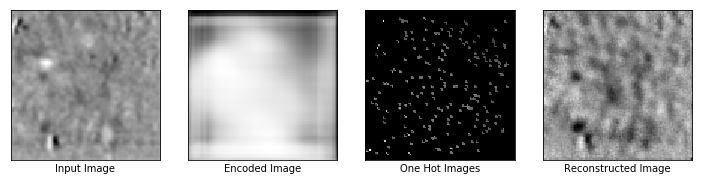

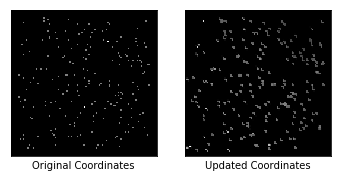

Epochs: 50, Reconstruction Loss: 0.0033815207425504923
Regularizer Loss: 28538.328125, Total Loss: 28538.33203125
Similarity Loss: 0.29074349999427795
Max Similarity scores: 0.9615065455436707
Updated Coordinates: [[[0.51880705 0.270585  ]]]
Gradient global min:-0.00033060956047847867, max:0.00028801715234294534
Gradient partial min:-0.10973432660102844, max:0.19280201196670532



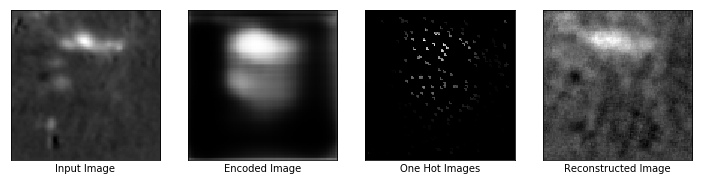

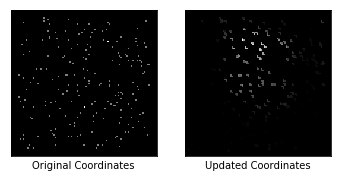

Epochs: 60, Reconstruction Loss: 0.003122773254290223
Regularizer Loss: 30291.830078125, Total Loss: 30291.833984375
Similarity Loss: 0.26770657300949097
Max Similarity scores: 0.9619359374046326
Updated Coordinates: [[[0.5187885  0.27051622]]]
Gradient global min:-0.0009321118704974651, max:0.0006713124457746744
Gradient partial min:-0.09699356555938721, max:0.1871114820241928



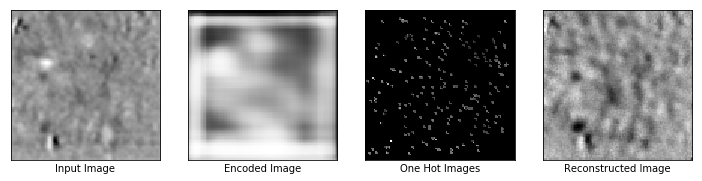

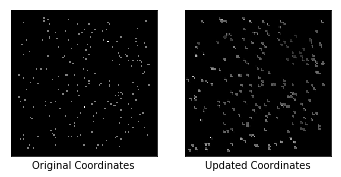

Epochs: 70, Reconstruction Loss: 0.0028164158575236797
Regularizer Loss: 32409.35546875, Total Loss: 32409.357421875
Similarity Loss: 0.23860742151737213
Max Similarity scores: 0.9806379675865173
Updated Coordinates: [[[0.5206284  0.26482838]]]
Gradient global min:-0.0007077397312968969, max:0.0006102530751377344
Gradient partial min:-0.08420120924711227, max:0.17434163391590118



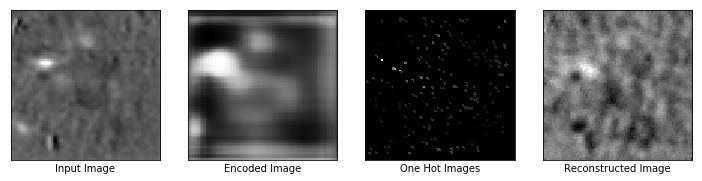

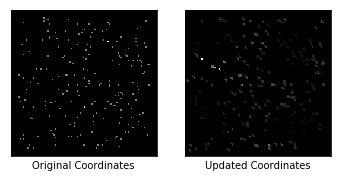

Epochs: 80, Reconstruction Loss: 0.002508054254576564
Regularizer Loss: 33066.0703125, Total Loss: 33066.07421875
Similarity Loss: 0.20944879949092865
Max Similarity scores: 0.9681375026702881
Updated Coordinates: [[[0.5191563  0.27009007]]]
Gradient global min:-0.0006368539179675281, max:0.0003393340448383242
Gradient partial min:-0.07358703017234802, max:0.15762017667293549



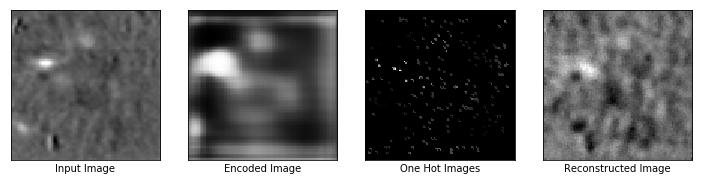

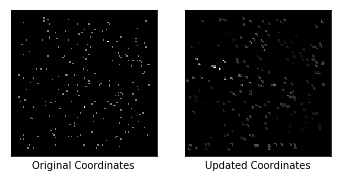

Epochs: 90, Reconstruction Loss: 0.0023029902949929237
Regularizer Loss: 33181.5625, Total Loss: 33181.56640625
Similarity Loss: 0.18499621748924255
Max Similarity scores: 0.9760238528251648
Updated Coordinates: [[[0.53062934 0.24498677]]]
Gradient global min:-0.0006946424255147576, max:0.0003667235723696649
Gradient partial min:-0.06563205271959305, max:0.13961286842823029



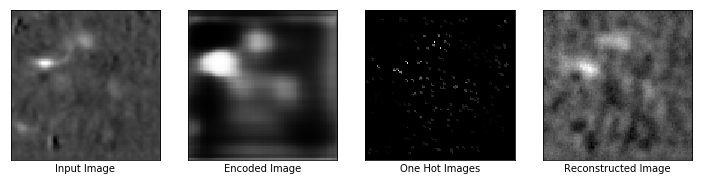

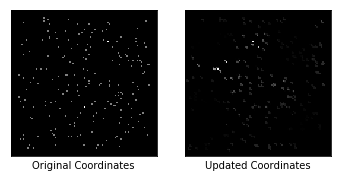

Epochs: 100, Reconstruction Loss: 0.002170752501115203
Regularizer Loss: 33325.1484375, Total Loss: 33325.15234375
Similarity Loss: 0.1708219051361084
Max Similarity scores: 0.961873471736908
Updated Coordinates: [[[0.50533825 0.25369114]]]
Gradient global min:-0.0017312988638877869, max:0.0021045259200036526
Gradient partial min:-0.060096994042396545, max:0.1271170824766159



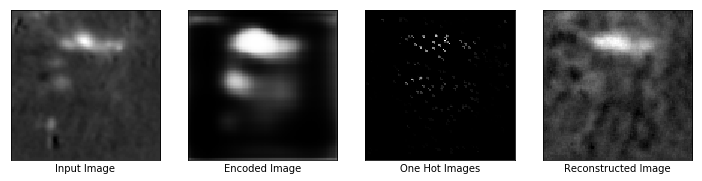

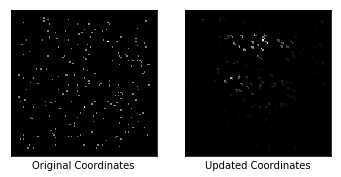

Epochs: 110, Reconstruction Loss: 0.0020883320830762386
Regularizer Loss: 33493.6015625, Total Loss: 33493.60546875
Similarity Loss: 0.15979057550430298
Max Similarity scores: 0.9944314360618591
Updated Coordinates: [[[0.49999028 0.23455271]]]
Gradient global min:-0.0015936886193230748, max:0.001112439320422709
Gradient partial min:-0.05622239038348198, max:0.11923143267631531



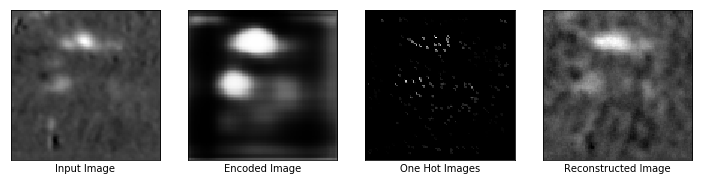

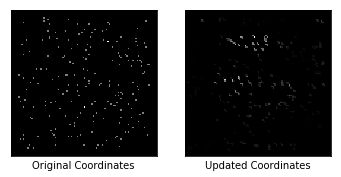

Epochs: 120, Reconstruction Loss: 0.001950083184055984
Regularizer Loss: 33734.57421875, Total Loss: 33734.57421875
Similarity Loss: 0.15151777863502502
Max Similarity scores: 0.9948570728302002
Updated Coordinates: [[[0.49910182 0.23036496]]]
Gradient global min:-0.002502159681171179, max:0.0028592790476977825
Gradient partial min:-0.05328891798853874, max:0.11339911818504333



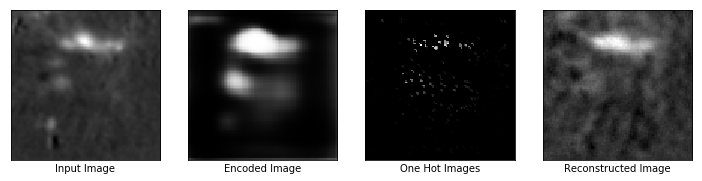

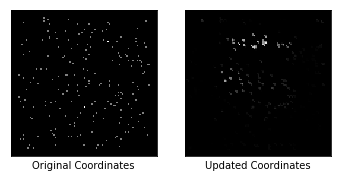

Epochs: 130, Reconstruction Loss: 0.0019183953991159797
Regularizer Loss: 33704.03125, Total Loss: 33704.03125
Similarity Loss: 0.1445903331041336
Max Similarity scores: 0.9925010204315186
Updated Coordinates: [[[0.49963987 0.21384871]]]
Gradient global min:-0.0016416861908510327, max:0.0012986203655600548
Gradient partial min:-0.05105841904878616, max:0.10826001316308975



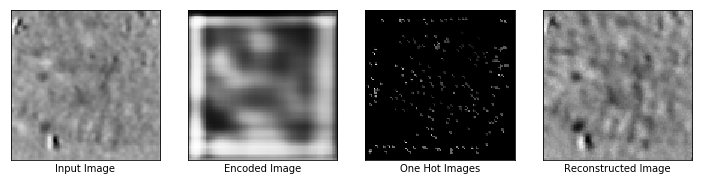

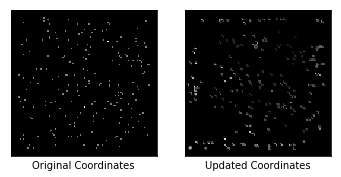

Epochs: 140, Reconstruction Loss: 0.0019134441390633583
Regularizer Loss: 33761.51171875, Total Loss: 33761.51171875
Similarity Loss: 0.14130637049674988
Max Similarity scores: 0.9480618238449097
Updated Coordinates: [[[0.4903464  0.21742254]]]
Gradient global min:-0.0042163534089922905, max:0.003253112081438303
Gradient partial min:-0.051077574491500854, max:0.10680477321147919



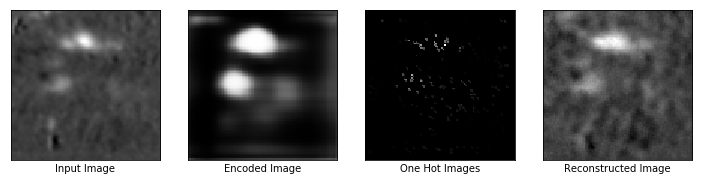

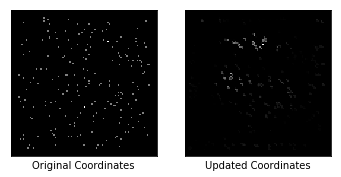

Epochs: 150, Reconstruction Loss: 0.001753146410919726
Regularizer Loss: 33158.265625, Total Loss: 33158.265625
Similarity Loss: 0.13078635931015015
Max Similarity scores: 0.9954336881637573
Updated Coordinates: [[[0.46791285 0.23030484]]]
Gradient global min:-0.0013016007142141461, max:0.0009312037727795541
Gradient partial min:-0.04966368153691292, max:0.102116160094738



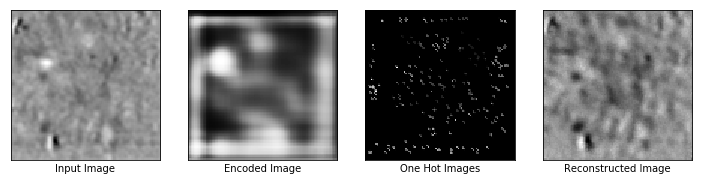

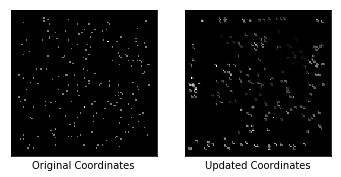

Epochs: 160, Reconstruction Loss: 0.002090065274387598
Regularizer Loss: 31779.125, Total Loss: 31779.126953125
Similarity Loss: 0.1093834936618805
Max Similarity scores: 0.938734233379364
Updated Coordinates: [[[0.4905434  0.24488944]]]
Gradient global min:-0.004266237374395132, max:0.005353714805096388
Gradient partial min:-0.041825201362371445, max:0.0907682329416275



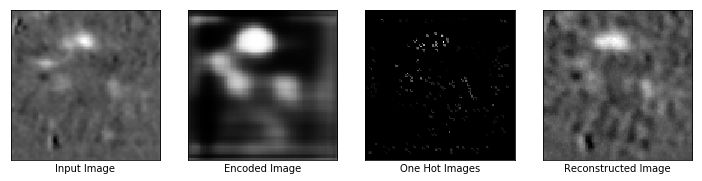

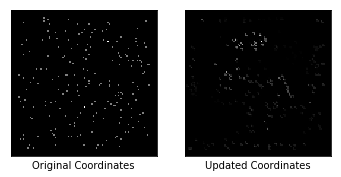

Epochs: 170, Reconstruction Loss: 0.0017462520627304912
Regularizer Loss: 32257.5703125, Total Loss: 32257.572265625
Similarity Loss: 0.10931016504764557
Max Similarity scores: 0.9896280765533447
Updated Coordinates: [[[0.47898862 0.24000183]]]
Gradient global min:-0.0008076614467427135, max:0.0004322653985582292
Gradient partial min:-0.042406633496284485, max:0.0877857506275177



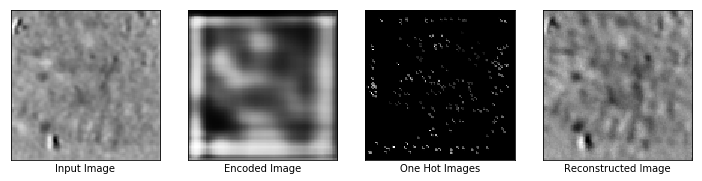

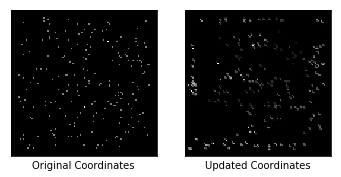

Epochs: 180, Reconstruction Loss: 0.0017513203201815486
Regularizer Loss: 32301.0390625, Total Loss: 32301.041015625
Similarity Loss: 0.1043214499950409
Max Similarity scores: 0.8793033957481384
Updated Coordinates: [[[0.50044024 0.22520769]]]
Gradient global min:-0.0028358465060591698, max:0.003618229879066348
Gradient partial min:-0.041656892746686935, max:0.08310586959123611



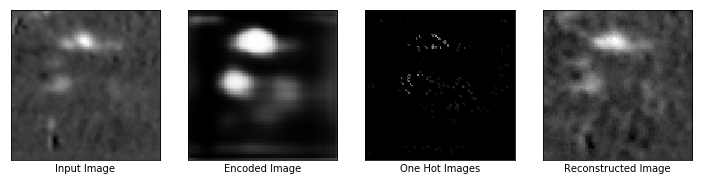

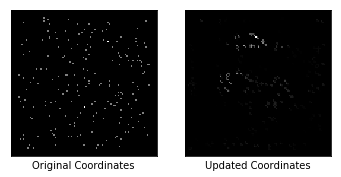

Epochs: 190, Reconstruction Loss: 0.001622656243853271
Regularizer Loss: 32509.66015625, Total Loss: 32509.662109375
Similarity Loss: 0.10185331106185913
Max Similarity scores: 0.9883634448051453
Updated Coordinates: [[[0.49841577 0.1899189 ]]]
Gradient global min:-0.002623105188831687, max:0.0011547019239515066
Gradient partial min:-0.0411544106900692, max:0.07723136991262436



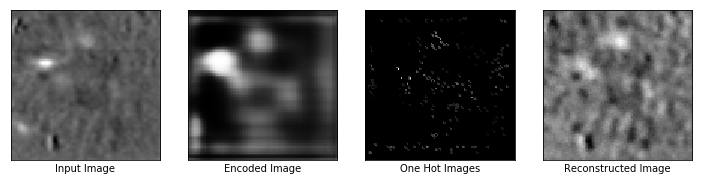

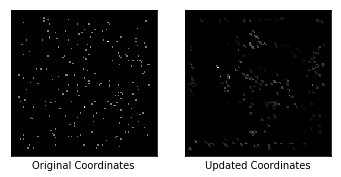

Epochs: 200, Reconstruction Loss: 0.0014943639980629086
Regularizer Loss: 32830.4375, Total Loss: 32830.4375
Similarity Loss: 0.10397019982337952
Max Similarity scores: 0.9477021098136902
Updated Coordinates: [[[0.50025904 0.18794061]]]
Gradient global min:-0.0005057213711552322, max:0.00029349260148592293
Gradient partial min:-0.041765883564949036, max:0.0773787647485733



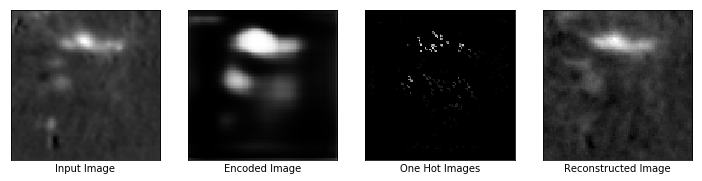

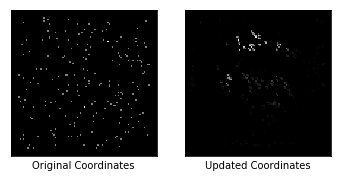

Epochs: 210, Reconstruction Loss: 0.0014308248646557331
Regularizer Loss: 32889.16015625, Total Loss: 32889.16015625
Similarity Loss: 0.10296103358268738
Max Similarity scores: 0.9901853799819946
Updated Coordinates: [[[0.50795424 0.16945186]]]
Gradient global min:-0.0011830802541226149, max:0.0011334293521940708
Gradient partial min:-0.041442953050136566, max:0.07715968787670135



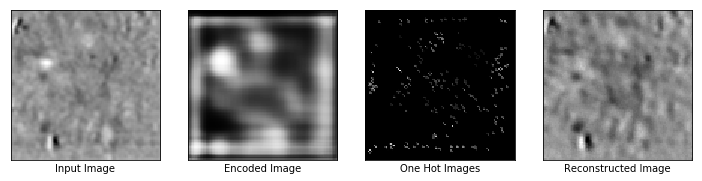

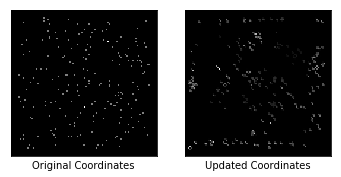

Epochs: 220, Reconstruction Loss: 0.0018306877464056015
Regularizer Loss: 32241.62109375, Total Loss: 32241.623046875
Similarity Loss: 0.08603031933307648
Max Similarity scores: 0.8920403122901917
Updated Coordinates: [[[0.50963724 0.15516411]]]
Gradient global min:-0.005389044992625713, max:0.007138331886380911
Gradient partial min:-0.034417130053043365, max:0.06738615036010742



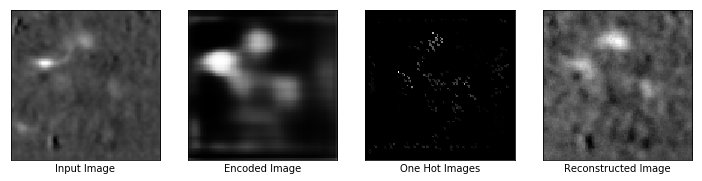

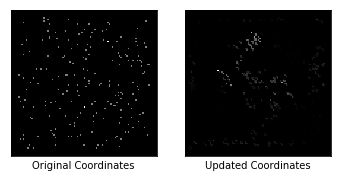

Epochs: 230, Reconstruction Loss: 0.0014417022466659546
Regularizer Loss: 31520.619140625, Total Loss: 31520.62109375
Similarity Loss: 0.08802024275064468
Max Similarity scores: 0.7354266047477722
Updated Coordinates: [[[0.47871232 0.18819042]]]
Gradient global min:-0.0031239355448633432, max:0.0012067528441548347
Gradient partial min:-0.03423206880688667, max:0.06068340316414833



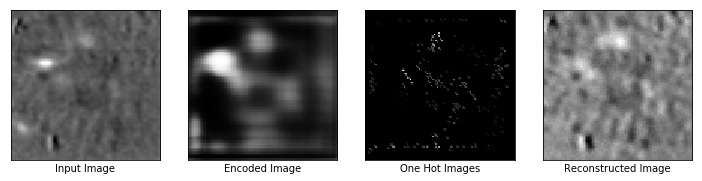

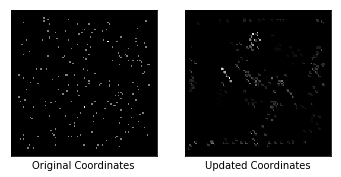

Epochs: 240, Reconstruction Loss: 0.0014181293081492186
Regularizer Loss: 31384.58984375, Total Loss: 31384.591796875
Similarity Loss: 0.08318640291690826
Max Similarity scores: 0.8560014367103577
Updated Coordinates: [[[0.49085963 0.16491233]]]
Gradient global min:-0.00132940080948174, max:0.00125505228061229
Gradient partial min:-0.033644337207078934, max:0.062353651970624924



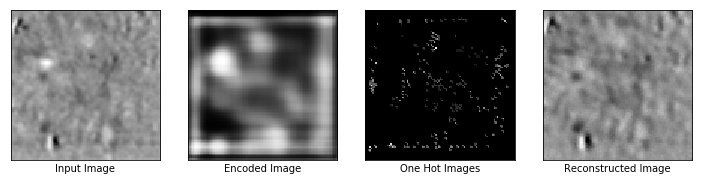

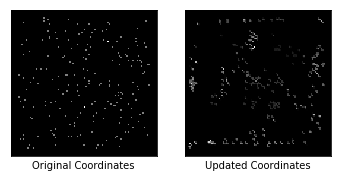

Epochs: 250, Reconstruction Loss: 0.0013613890623673797
Regularizer Loss: 31549.09375, Total Loss: 31549.095703125
Similarity Loss: 0.08275013417005539
Max Similarity scores: 0.8801290988922119
Updated Coordinates: [[[0.4692133  0.15971465]]]
Gradient global min:-0.0011322342325001955, max:0.0014662048779428005
Gradient partial min:-0.032670941203832626, max:0.06531524658203125



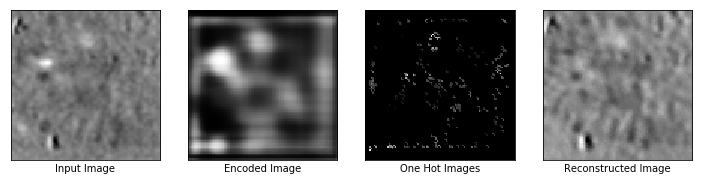

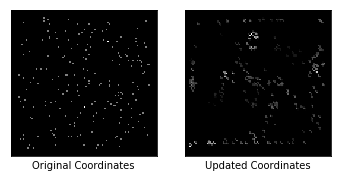

Epochs: 260, Reconstruction Loss: 0.0014641752932220697
Regularizer Loss: 31664.544921875, Total Loss: 31664.546875
Similarity Loss: 0.07972342520952225
Max Similarity scores: 0.8153377175331116
Updated Coordinates: [[[0.45216998 0.15734355]]]
Gradient global min:-0.0021316336933523417, max:0.0028508170507848263
Gradient partial min:-0.030591052025556564, max:0.06328713893890381



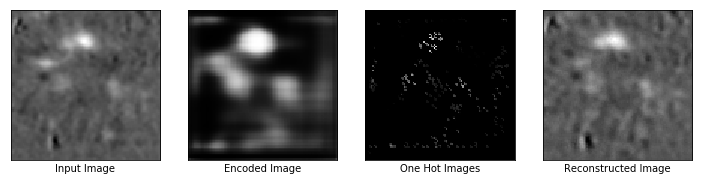

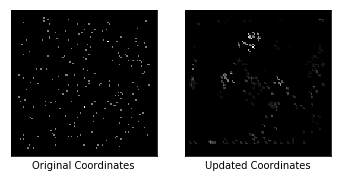

Epochs: 270, Reconstruction Loss: 0.0014672672841697931
Regularizer Loss: 31755.8125, Total Loss: 31755.814453125
Similarity Loss: 0.08079128712415695
Max Similarity scores: 0.9595539569854736
Updated Coordinates: [[[0.43864208 0.16392966]]]
Gradient global min:-0.0006680040969513357, max:0.00039543042657896876
Gradient partial min:-0.02959478460252285, max:0.0626281350851059



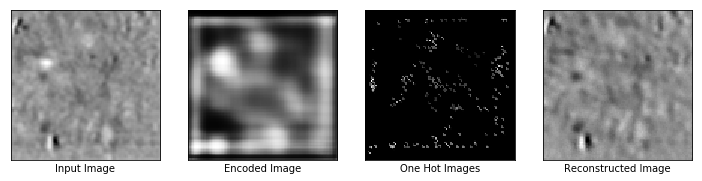

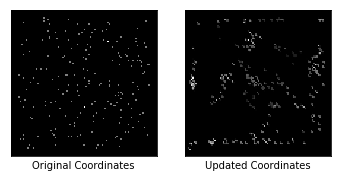

Epochs: 280, Reconstruction Loss: 0.001420223037712276
Regularizer Loss: 31717.46484375, Total Loss: 31717.466796875
Similarity Loss: 0.08554479479789734
Max Similarity scores: 0.8988654613494873
Updated Coordinates: [[[0.4411259  0.15055697]]]
Gradient global min:-0.0008609431097283959, max:0.0007220121333375573
Gradient partial min:-0.030522514134645462, max:0.06105579063296318



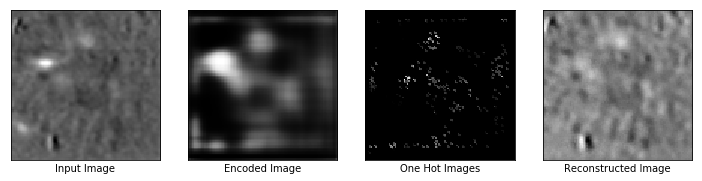

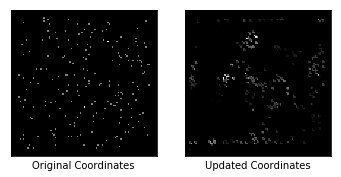

Epochs: 290, Reconstruction Loss: 0.0015397886745631695
Regularizer Loss: 31470.19921875, Total Loss: 31470.201171875
Similarity Loss: 0.07190749794244766
Max Similarity scores: 0.6392509341239929
Updated Coordinates: [[[0.43939415 0.15403345]]]
Gradient global min:-0.002606484107673168, max:0.0027858419343829155
Gradient partial min:-0.027744373306632042, max:0.055795490741729736



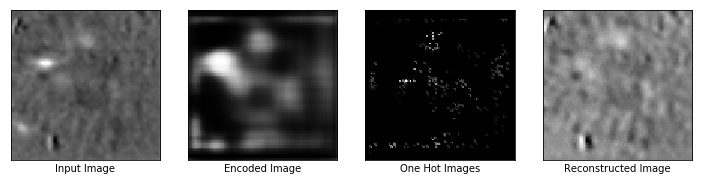

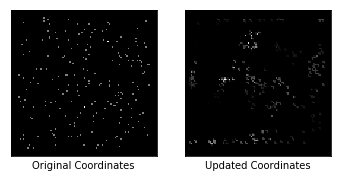

Epochs: 300, Reconstruction Loss: 0.0014534674119204283
Regularizer Loss: 31712.73828125, Total Loss: 31712.740234375
Similarity Loss: 0.0755472406744957
Max Similarity scores: 0.6462326645851135
Updated Coordinates: [[[0.4507883 0.1482018]]]
Gradient global min:-0.0011813341407105327, max:0.0012138716410845518
Gradient partial min:-0.02706754021346569, max:0.057009972631931305



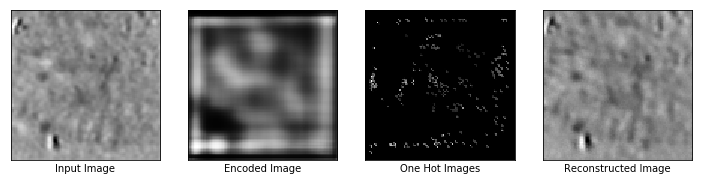

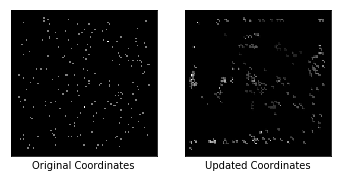

Epochs: 310, Reconstruction Loss: 0.0014536778908222914
Regularizer Loss: 31902.541015625, Total Loss: 31902.54296875
Similarity Loss: 0.07271839678287506
Max Similarity scores: 0.8776359558105469
Updated Coordinates: [[[0.47883093 0.162588  ]]]
Gradient global min:-0.004260261543095112, max:0.004679444711655378
Gradient partial min:-0.027503108605742455, max:0.05486190319061279



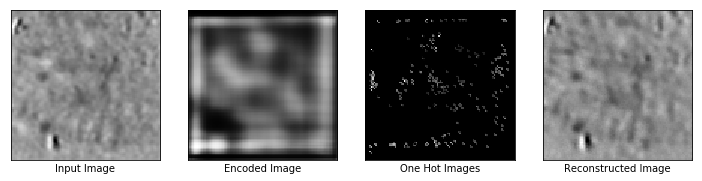

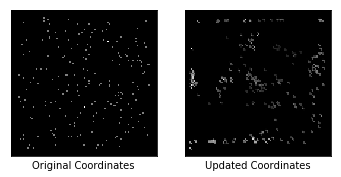

Epochs: 320, Reconstruction Loss: 0.0014046194264665246
Regularizer Loss: 31968.8671875, Total Loss: 31968.869140625
Similarity Loss: 0.07251862436532974
Max Similarity scores: 0.8936800956726074
Updated Coordinates: [[[0.45725372 0.16921456]]]
Gradient global min:-0.0021912839729338884, max:0.0022504013031721115
Gradient partial min:-0.028055625036358833, max:0.0547969751060009



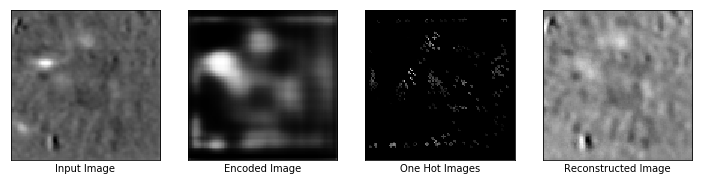

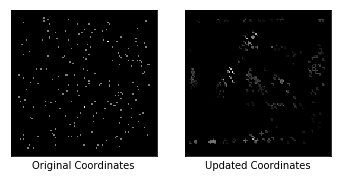

Epochs: 330, Reconstruction Loss: 0.0013382160104811192
Regularizer Loss: 31862.5, Total Loss: 31862.501953125
Similarity Loss: 0.07086853682994843
Max Similarity scores: 0.7633718848228455
Updated Coordinates: [[[0.46801543 0.17989986]]]
Gradient global min:-0.0007083467207849026, max:0.0006818331312388182
Gradient partial min:-0.026328446343541145, max:0.05592634901404381



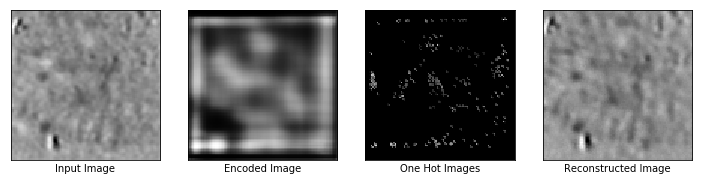

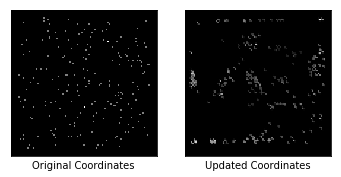

Epochs: 340, Reconstruction Loss: 0.0013687986647710204
Regularizer Loss: 31557.8984375, Total Loss: 31557.900390625
Similarity Loss: 0.06587976217269897
Max Similarity scores: 0.8590522408485413
Updated Coordinates: [[[0.4772046 0.1792765]]]
Gradient global min:-0.0022473118733614683, max:0.002197175519540906
Gradient partial min:-0.02554931305348873, max:0.055214907974004745



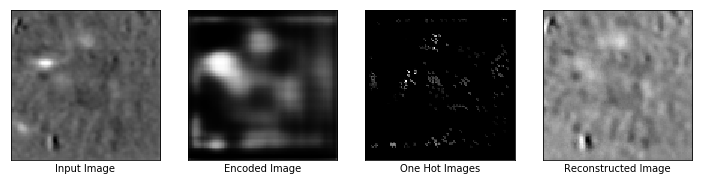

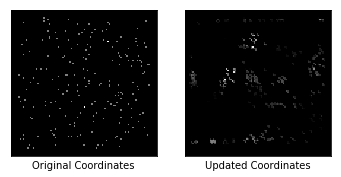

Epochs: 350, Reconstruction Loss: 0.0013600313104689121
Regularizer Loss: 31498.73828125, Total Loss: 31498.740234375
Similarity Loss: 0.06902628391981125
Max Similarity scores: 0.7625622749328613
Updated Coordinates: [[[0.46962643 0.17057425]]]
Gradient global min:-0.001924572279676795, max:0.0010990153532475233
Gradient partial min:-0.026004081591963768, max:0.05767734348773956



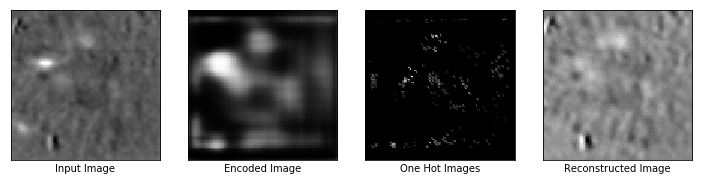

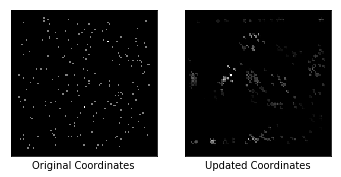

Epochs: 360, Reconstruction Loss: 0.0017188213532790542
Regularizer Loss: 31193.17578125, Total Loss: 31193.177734375
Similarity Loss: 0.07591584324836731
Max Similarity scores: 0.7318891882896423
Updated Coordinates: [[[0.4706551  0.16506141]]]
Gradient global min:-0.0044676135294139385, max:0.0035019174683839083
Gradient partial min:-0.028422951698303223, max:0.06596031039953232



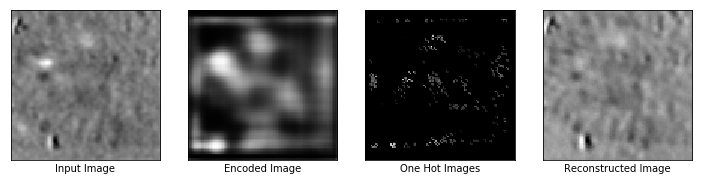

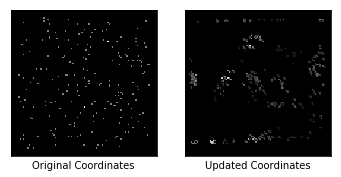

Epochs: 370, Reconstruction Loss: 0.0014766411622986197
Regularizer Loss: 30342.12890625, Total Loss: 30342.130859375
Similarity Loss: 0.05641501396894455
Max Similarity scores: 0.83685702085495
Updated Coordinates: [[[0.479395   0.18388161]]]
Gradient global min:-0.0026593655347824097, max:0.0027493000961840153
Gradient partial min:-0.021872172132134438, max:0.05450630560517311



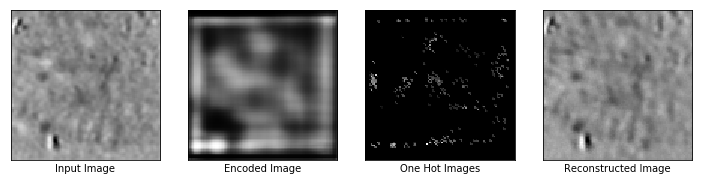

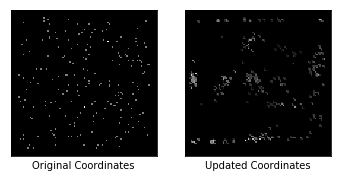

Epochs: 380, Reconstruction Loss: 0.001338484580628574
Regularizer Loss: 30360.30078125, Total Loss: 30360.302734375
Similarity Loss: 0.05788791552186012
Max Similarity scores: 0.8806523084640503
Updated Coordinates: [[[0.46911356 0.19587359]]]
Gradient global min:-0.0030341127421706915, max:0.002923645544797182
Gradient partial min:-0.022775923833251, max:0.055601511150598526



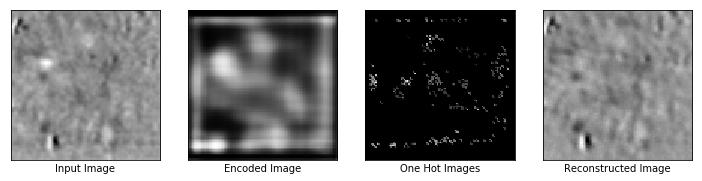

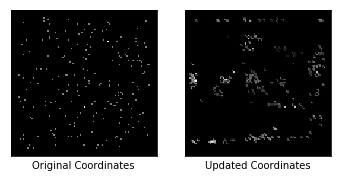

Epochs: 390, Reconstruction Loss: 0.0012836933601647615
Regularizer Loss: 30805.8125, Total Loss: 30805.814453125
Similarity Loss: 0.05867761746048927
Max Similarity scores: 0.8776015639305115
Updated Coordinates: [[[0.50019866 0.19448318]]]
Gradient global min:-0.0015447682235389948, max:0.001537610194645822
Gradient partial min:-0.023876002058386803, max:0.05727357044816017



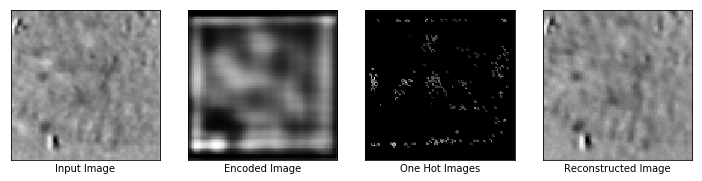

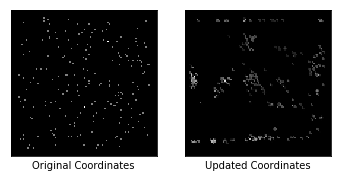

Epochs: 400, Reconstruction Loss: 0.0012865460012108088
Regularizer Loss: 31148.671875, Total Loss: 31148.673828125
Similarity Loss: 0.061459947377443314
Max Similarity scores: 0.8751783967018127
Updated Coordinates: [[[0.46911478 0.18339632]]]
Gradient global min:-0.0037080736365169287, max:0.0036741397343575954
Gradient partial min:-0.025366561487317085, max:0.060519613325595856



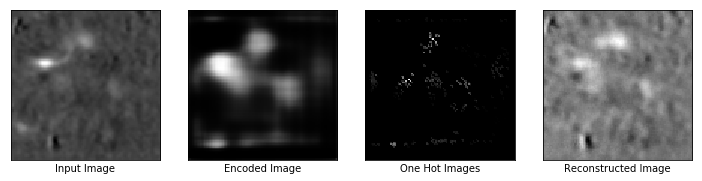

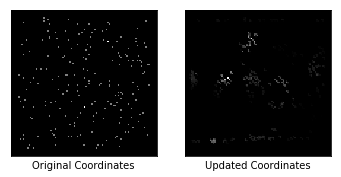

Epochs: 410, Reconstruction Loss: 0.0012459871359169483
Regularizer Loss: 31591.41796875, Total Loss: 31591.419921875
Similarity Loss: 0.06363066285848618
Max Similarity scores: 0.6442375183105469
Updated Coordinates: [[[0.46969232 0.20713359]]]
Gradient global min:-0.0010300015565007925, max:0.001228943350724876
Gradient partial min:-0.026817576959729195, max:0.06480330973863602



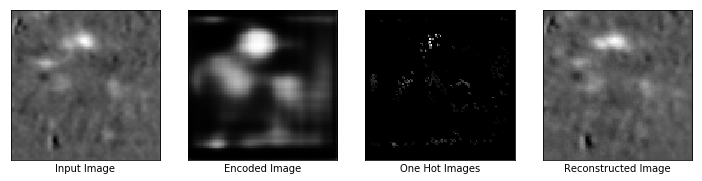

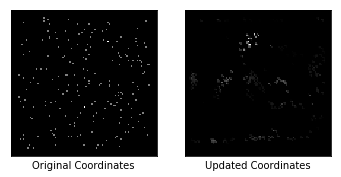

Epochs: 420, Reconstruction Loss: 0.001331066363491118
Regularizer Loss: 32022.03515625, Total Loss: 32022.037109375
Similarity Loss: 0.06270205974578857
Max Similarity scores: 0.9340093731880188
Updated Coordinates: [[[0.47909284 0.17866409]]]
Gradient global min:-0.0004680742567870766, max:0.0005009863525629044
Gradient partial min:-0.026319390162825584, max:0.06414849311113358



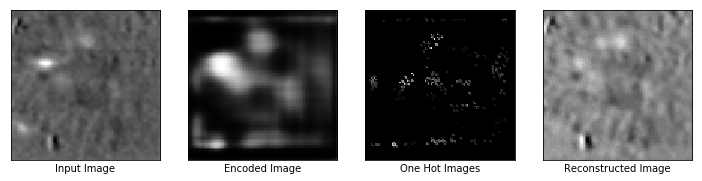

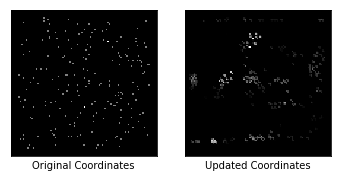

Epochs: 430, Reconstruction Loss: 0.0014684577472507954
Regularizer Loss: 32161.7890625, Total Loss: 32161.791015625
Similarity Loss: 0.06428226083517075
Max Similarity scores: 0.6942326426506042
Updated Coordinates: [[[0.48690853 0.15914585]]]
Gradient global min:-0.0032131923362612724, max:0.001989112701267004
Gradient partial min:-0.024980558082461357, max:0.06891997158527374



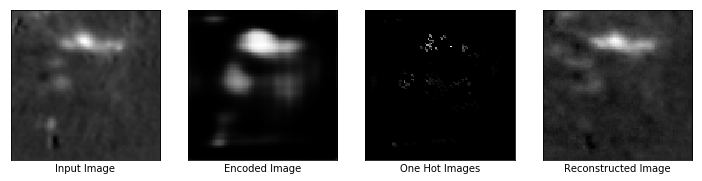

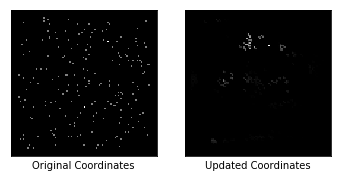

Epochs: 440, Reconstruction Loss: 0.0013261842541396618
Regularizer Loss: 32126.318359375, Total Loss: 32126.3203125
Similarity Loss: 0.05472920089960098
Max Similarity scores: 0.9076380729675293
Updated Coordinates: [[[0.44275182 0.1761627 ]]]
Gradient global min:-0.00133821542840451, max:0.0010832056868821383
Gradient partial min:-0.022248517721891403, max:0.06165294721722603



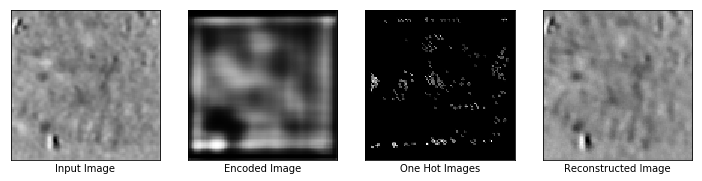

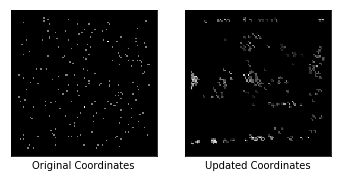

Epochs: 450, Reconstruction Loss: 0.0013150481972843409
Regularizer Loss: 32547.609375, Total Loss: 32547.611328125
Similarity Loss: 0.05396591126918793
Max Similarity scores: 0.8844735622406006
Updated Coordinates: [[[0.40863854 0.18388526]]]
Gradient global min:-0.002981815952807665, max:0.002610308350995183
Gradient partial min:-0.023196913301944733, max:0.060563236474990845



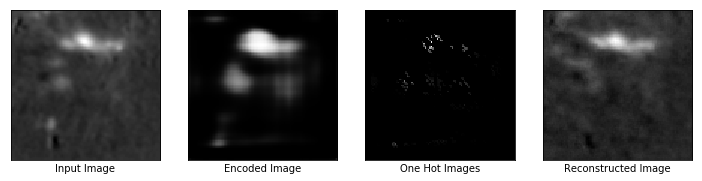

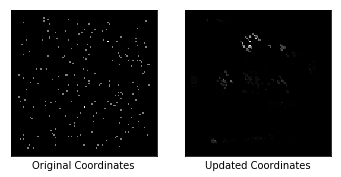

Epochs: 460, Reconstruction Loss: 0.0013235557125881314
Regularizer Loss: 32945.86328125, Total Loss: 32945.86328125
Similarity Loss: 0.05560428649187088
Max Similarity scores: 0.9078325033187866
Updated Coordinates: [[[0.41833562 0.18444148]]]
Gradient global min:-0.0018335238564759493, max:0.002274042461067438
Gradient partial min:-0.02547263726592064, max:0.06544440239667892



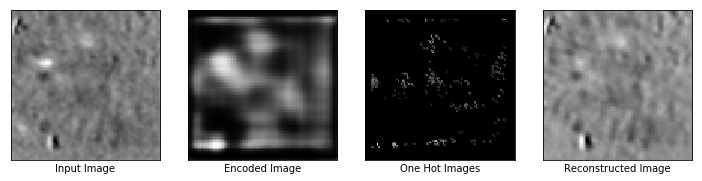

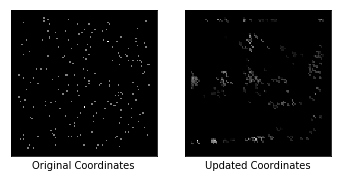

Epochs: 470, Reconstruction Loss: 0.0012793875066563487
Regularizer Loss: 33117.125, Total Loss: 33117.125
Similarity Loss: 0.054131880402565
Max Similarity scores: 0.8576875329017639
Updated Coordinates: [[[0.42821866 0.20303793]]]
Gradient global min:-0.004434642847627401, max:0.0024350080639123917
Gradient partial min:-0.02510596066713333, max:0.06355011463165283


In [ ]:
batch_imgs= tf.data.Dataset.from_tensor_slices(re_list).batch(BATCH_SIZE, drop_remainder=True)

#list to be append to output 
loss_list_global = []
loss_list_encoded_one_hot = []
regulariser_loss_list = []
input_imgs = []
coords_list = []
encoded_imgs = []
reconstructed_imgs = []
one_hot_imgs_list = []
similarity_list = []

captions_01 = ['Input Image', 'Encoded Image', 'One Hot Images','Reconstructed Image']
captions_02 = ['Original Coordinates', 'Updated Coordinates']

#list to append to monitor each frames for the last epochs 
one_hot_imgs_last_list = []
encoder_output_last_list = []
similarity_score_last_list = []
reconstruction_last_list = []

epochs = 1
while epochs <= MAX_EPOCHS:
    #reset coords for each epochs
#     coords,_, ori_one_hot_imgs = create_dat_samples(n_neurons)
#     coords = tf.reshape(coords, [n_neurons, 1,1,2])
    for steps, batched_imgs in enumerate(batch_imgs):
        loss, updated_coords, one_hot_imgs, encoder_output, similarity_score, reconstruction, grad = train_fn(batched_imgs, coords, 
                                                                                                              IMG_SIZE, BATCH_SIZE,
                                                                                                             one_hot_thr = False)
        #append all frames for final epochs!
        if epochs==MAX_EPOCHS:
            one_hot_imgs_last_list.append(one_hot_imgs)
            encoder_output_last_list.append(encoder_output)
            similarity_score_last_list.append(similarity_score)
            reconstruction_last_list.append(reconstruction)
    #loss is append for each epochs
    loss_list_global.append(loss[0])
    loss_list_encoded_one_hot.append(loss[1])
    regulariser_loss_list.append(loss[-1])
    
    rand = randint(0, BATCH_SIZE-1) #random number to generate for plotting outputs 
    if epochs%10==0:
        img_row01 = [batched_imgs[rand], encoder_output[rand], similarity_multi(n_neurons, one_hot_imgs, similarity_score[rand], IMG_SIZE), reconstruction[rand]]
        img_row02 = [stack4plot(ori_one_hot_imgs), similarity_multi(n_neurons, one_hot_imgs, similarity_score[rand], IMG_SIZE)]
        plot_comparison(img_row01, captions_01, n_col=len(img_row01), figsize = (10, 10))
        plot_comparison(img_row02, captions_02, n_col=len(img_row02))
        print("Epochs: {}, Reconstruction Loss: {}".format(epochs, loss[0].numpy()))
        print("Regularizer Loss: {}, Total Loss: {}".format(loss[-1].numpy(), loss[0].numpy()+loss[-1].numpy()))
        print("Similarity Loss: {}".format(loss[1].numpy()))
        print("Max Similarity scores: {}".format(np.max(similarity_score[rand])))
        print("Updated Coordinates: {}".format(updated_coords[0]))
        print("Gradient global min:{}, max:{}".format(np.min(grad[0][rand]), np.max(grad[0][rand])))
        print("Gradient partial min:{}, max:{}".format(np.min(grad[1][0]), np.max(grad[1][0])))
    #append list for every 100 epochs 
#     if epochs%100==0:
        encoded_imgs.append(encoder_output)
        input_imgs.append(batched_imgs)
        coords_list.append(updated_coords)
        reconstructed_imgs.append(reconstruction)
        one_hot_imgs_list.append(one_hot_imgs)
        similarity_list.append(similarity_score)
        
    epochs+=1

----

# Save Output Data

In [13]:
save_list = [loss_list_global, loss_list_encoded_one_hot, input_imgs, coords_list, encoded_imgs, reconstructed_imgs, one_hot_imgs_list, similarity_list]
save_names = ['loss_list_global', 'loss_list_encoded_one_hot', 'input_imgs', 'coords_list', 'encoded_imgs', 'reconstructed_imgs', 'one_hot_imgs_list', 'similarity_list']

directory = '/home/kevinteng/Desktop/npy/{}'.format(ver)
#make directory to save
if not os.path.exists(directory):
    os.makedirs(directory)
    
for names, items in zip(save_names, save_list):
    tensor = tf.convert_to_tensor(items, tf.float32)
    np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, names, ver), np.array(tensor))
    

In [14]:
#save coords and one hot images()
np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'ori_coords', ver), np.array(coords))
np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'ori_one_hot_imgs', ver), np.array(ori_one_hot_imgs))

In [15]:
#save info for every frames in last epochs
save_list_last = [encoder_output_last_list, similarity_score_last_list, reconstruction_last_list]
save_names_last = ['encoder_output_last_list', 'similarity_score_last_list', 'reconstruction_last_list']

for names, items in zip(save_names_last, save_list_last):
    aggregate_tensor = utils.concat_batch(items)
    np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, names, ver), np.array(aggregate_tensor))

In [16]:
#save one hot imgs for last epochs 
tensor = tf.convert_to_tensor(one_hot_imgs_last_list, tf.float32) #(frames/batch, n_neurons, img_size, img_size, 1)
np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'one_hot_imgs_last_list', ver), np.array(tensor))

In [17]:
#save weights
encoder_model.save_weights('model_weights/encoder_model_{}.h5'.format(ver))
decoder_model.save_weights('model_weights/decoder_model_{}.h5'.format(ver))

---

# Visualization

In [18]:
# coords list for every 100 epochs (max_epochs/100, n_neurons, 1, 1, 2)
coords_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'coords_list', ver)) 
# encoder output first batch for every 100 epochs (max_epochs/100, 8, 100, 100, 1)
encoded_imgs_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'encoded_imgs', ver))
# input image first batch for every 100 epochs (max_epochs/100, 8, 100, 100, 1)
input_imgs_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'input_imgs', ver))
# global loss for every epochs
loss_list_global_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'loss_list_global', ver))
#similarity loss for every epochs
loss_list_encoded_one_hot_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'loss_list_encoded_one_hot', ver))
# one hot images first batch for every 100 epochs  (max_epochs/100, n_neurons, 100, 100, 1)
one_hot_imgs_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'one_hot_imgs_list', ver))
# reconstructed images first batch for every 100 epochs (max_epochs/100, 8, 100, 100, 1)
reconstructed_imgs_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'reconstructed_imgs', ver))
# similarity batch for every 100 epochs (max_epochs/100, 8, n_neurons)
similarity_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'similarity_list', ver))
#original coords list (n_neurons, 1, 1, 2)
ori_coords_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'ori_coords', ver))
#original one hot image (n_neurons, 100, 100, 1)
ori_one_hot_imgs_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'ori_one_hot_imgs', ver))

In [19]:
#load roi mask
roi_img = np.load('/home/kevinteng/Desktop/Manual_annotation/DG-13-3-8-17_ROImask.npy')
roi_img = cv2.resize(roi_img, (100, 100))
# plt.imshow(roi_img, cmap = 'gray')

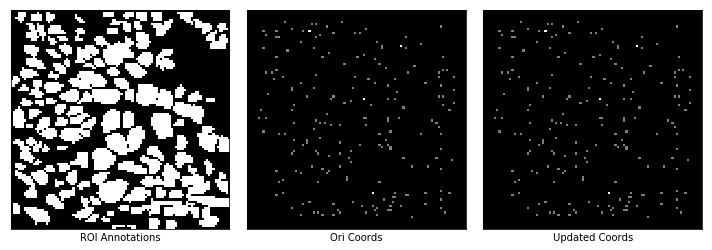

In [20]:
#comparison of roi and one hot images 
captions_03 = ['ROI Annotations', 'Ori Coords', 'Updated Coords']
img_row03 = [roi_img, stack4plot(ori_one_hot_imgs_npy), stack4plot(one_hot_imgs_list_npy[-1])]
plot_comparison(img_row03, captions_03, n_col=len(img_row03), figsize = (10, 10))

Mean value:  0.020000001
Counts:  196


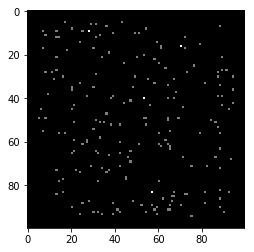

In [21]:
sum_updated_coords = stack4plot(one_hot_imgs_list_npy[-1])
print("Mean value: ", np.mean(sum_updated_coords))
updated_coords_img = np.where(sum_updated_coords<0.1, 0, sum_updated_coords) 
activations_count = np.count_nonzero(updated_coords_img!=0)
print("Counts: ", activations_count)
plt.imshow(updated_coords_img, cmap = 'gray')

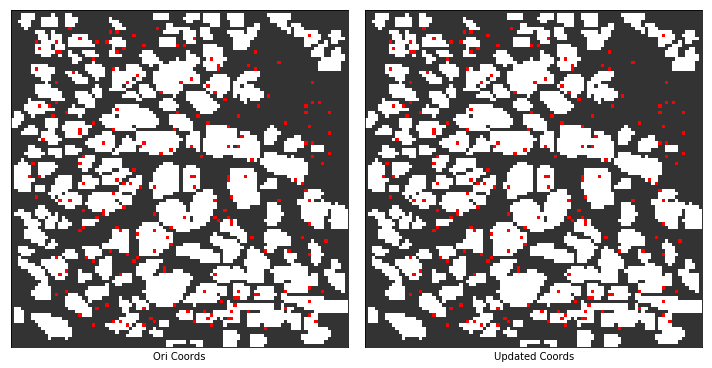

In [22]:
#define color
col = [(0.2, 0.2, 0.2),(1,1,1),(1,0,0)] 
cm = LinearSegmentedColormap.from_list('mylist', col, 3)  
#     #Bins for cmap
bounds=[0,1,5,10]
norm = BoundaryNorm(bounds, cm.N)
#overlap mask with original coordinates 
roi_ori_mask = overlapMasks02(roi_img, stack4plot(ori_one_hot_imgs_npy))

#overlap mask with updated coordinates 
roi_updated_mask = overlapMasks02(roi_img, updated_coords_img)

captions_04 = ['Ori Coords', 'Updated Coords']
img_row04 = [roi_ori_mask, roi_updated_mask]
plot_comparison(img_row04, captions_04, n_col=len(img_row04), figsize = (10, 10), cmap = cm, norm = norm)

In [23]:
#confusion matrix 
confMatrix = utils_model.getConfusionMatrix(roi_img, updated_coords_img)

print("True Positives: ", confMatrix[0])
print("True Negatives: ", confMatrix[1])
print("False Positive Ratio: ", confMatrix[2])
print("False Negatives Ratio: ", confMatrix[3])
print("F1 score: ", utils_model.f1score(confMatrix))

True Positives:  0.0102
True Negatives:  0.0094
False Positive Ratio:  0.4084
False Negatives Ratio:  0.5720000000000001
F1 score:  0.04655408489274305


---

# Similarity Scores with Threshold

In [26]:
neuron_activations, neuron_activations_thr = similarity_multiplication(similarity_list_npy, one_hot_imgs_list_npy, 
                                                                       n_neurons, epoch_pos=-1, 
                                                                       img_size = IMG_SIZE, threshold = 0.7)

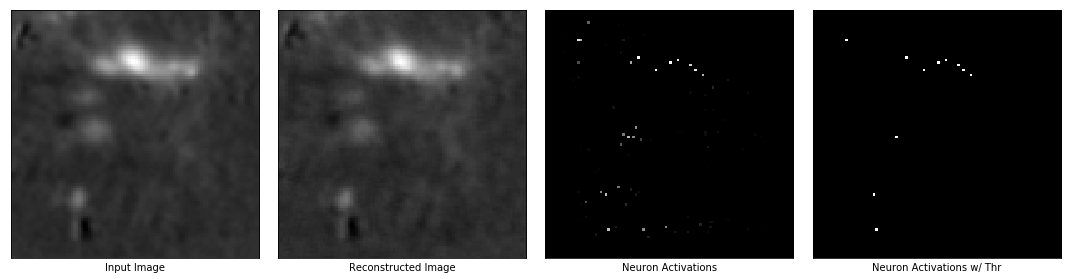

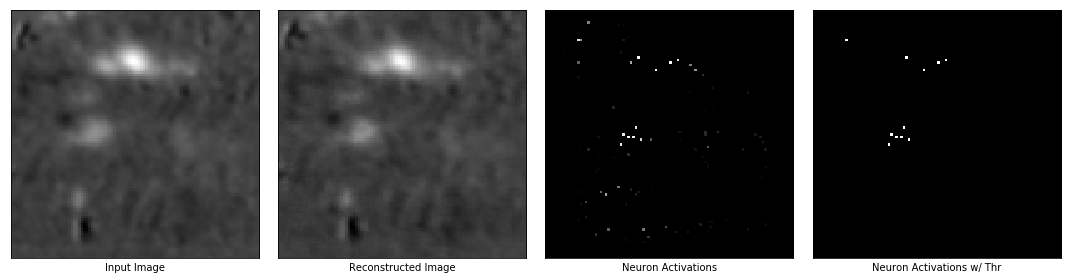

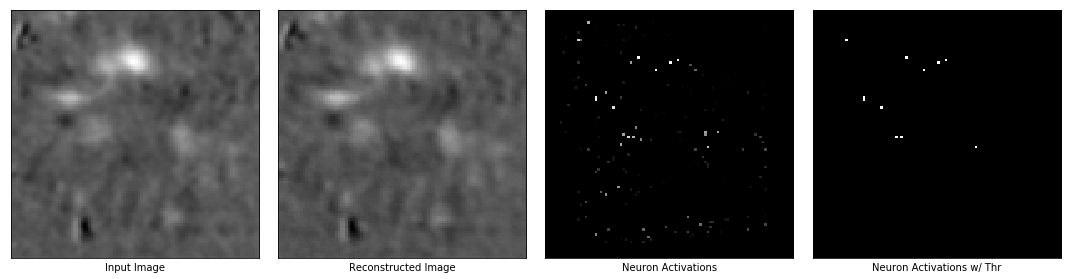

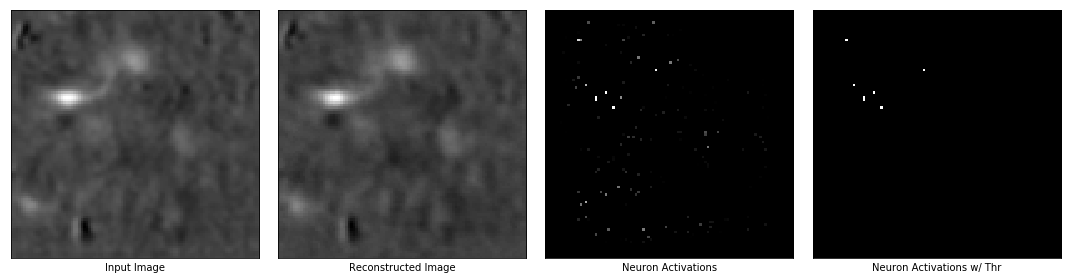

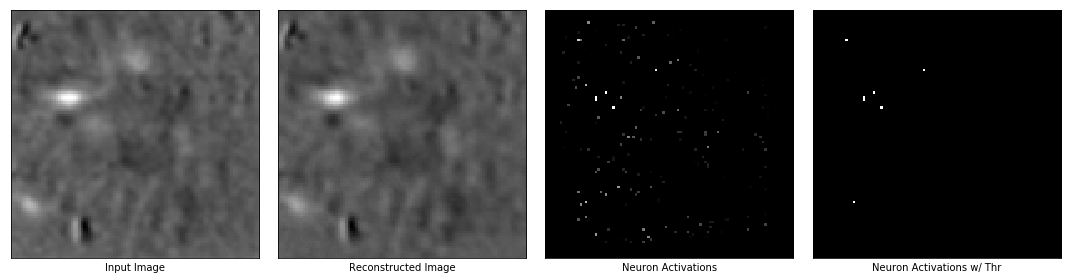

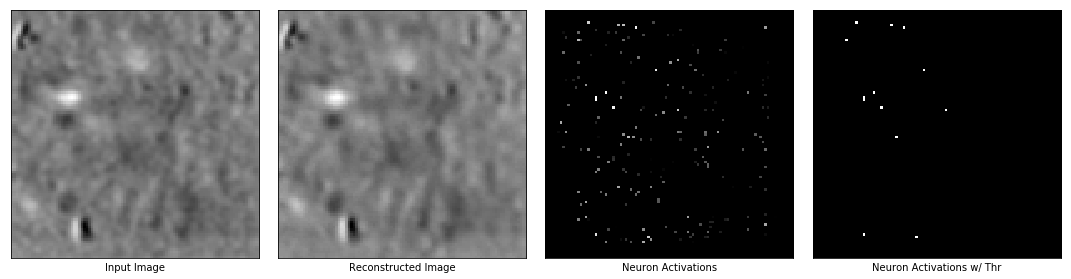

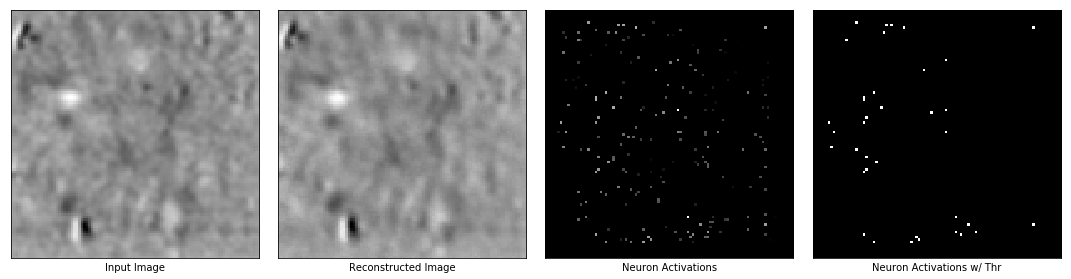

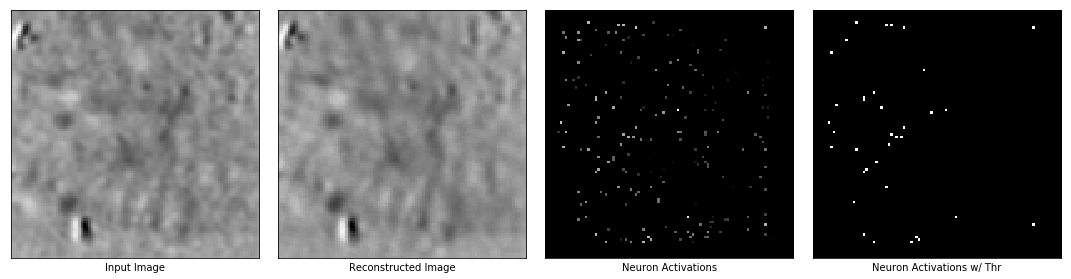

In [27]:
batch_size = BATCH_SIZE
captions_03 = ['Input Image', 'Reconstructed Image','Neuron Activations', 'Neuron Activations w/ Thr']
for i in range(batch_size):
    img_row03 = [np.squeeze(input_imgs_npy[-1,i]), np.squeeze(reconstructed_imgs_npy[-1,i]), neuron_activations[i], neuron_activations_thr[i]]
    plot_comparison(img_row03, captions_03, n_col=len(img_row03), figsize = (15, 15))

## Loss Plot

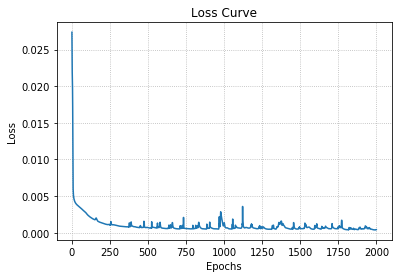

In [28]:
#plot loss
xlabel = 'Epochs'
ylabel = 'Loss'
title = 'Loss Curve'
utils_vis.plot_loss(loss_list_global_npy, xlabel, ylabel, title)

## Feature Maps

In [29]:
#build encoder 
inps = Input(shape=(IMG_SIZE, IMG_SIZE, 1))
encoder_model = Model(inps, encoder(inps, IMG_SIZE))
encoder_model.load_weights("model_weights/encoder_model_{}.h5".format(ver))
#build coord model
inp = Input(shape=(100, 100,2)) #(batch_size, img_size, img_size, 2)
de_coordconv = Model(inp, de_conv(inp))
de_coordconv.load_weights("best_class_model100_02.hdf5")

#decoder
latent_dim = Input(shape=(n_neurons, 3, 1))
decoder_model = Model(latent_dim, decoder(latent_dim))
decoder_model.load_weights("model_weights/decoder_model_{}.h5".format(ver))

#learnable coords
l_coords = learnable_coords(ori_coords_npy)

In [30]:
decoder_layers_name = utils_vis.layers_name(decoder_model) 

input_6
flatten_3
dense_1
reshape_1
up_sampling2d_8
coord_conv_9
activation_2
up_sampling2d_9
conv2d_36
activation_3
conv2d_37


In [31]:
#concat latent space as input
squeeze_coords = np.squeeze(coords_list_npy[-1]) #use the last pos
similarity_score = similarity_list_npy[-1]


concat = tf.stack((squeeze_coords[:,-2], squeeze_coords[:,-1], similarity_score[0]), axis=-1)
concat_ex = concat[np.newaxis,:,:,np.newaxis] #extand axis=0 and axis=-1 for input into model
print(concat_ex.shape)

(1, 200, 3, 1)


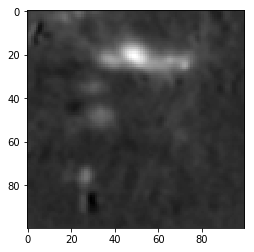

In [32]:
plt.imshow(np.squeeze(input_imgs_npy[-1,0]), cmap = 'gray')

Shape of feature maps: (1, 50, 50, 64)
Number of feature maps in layer:  64


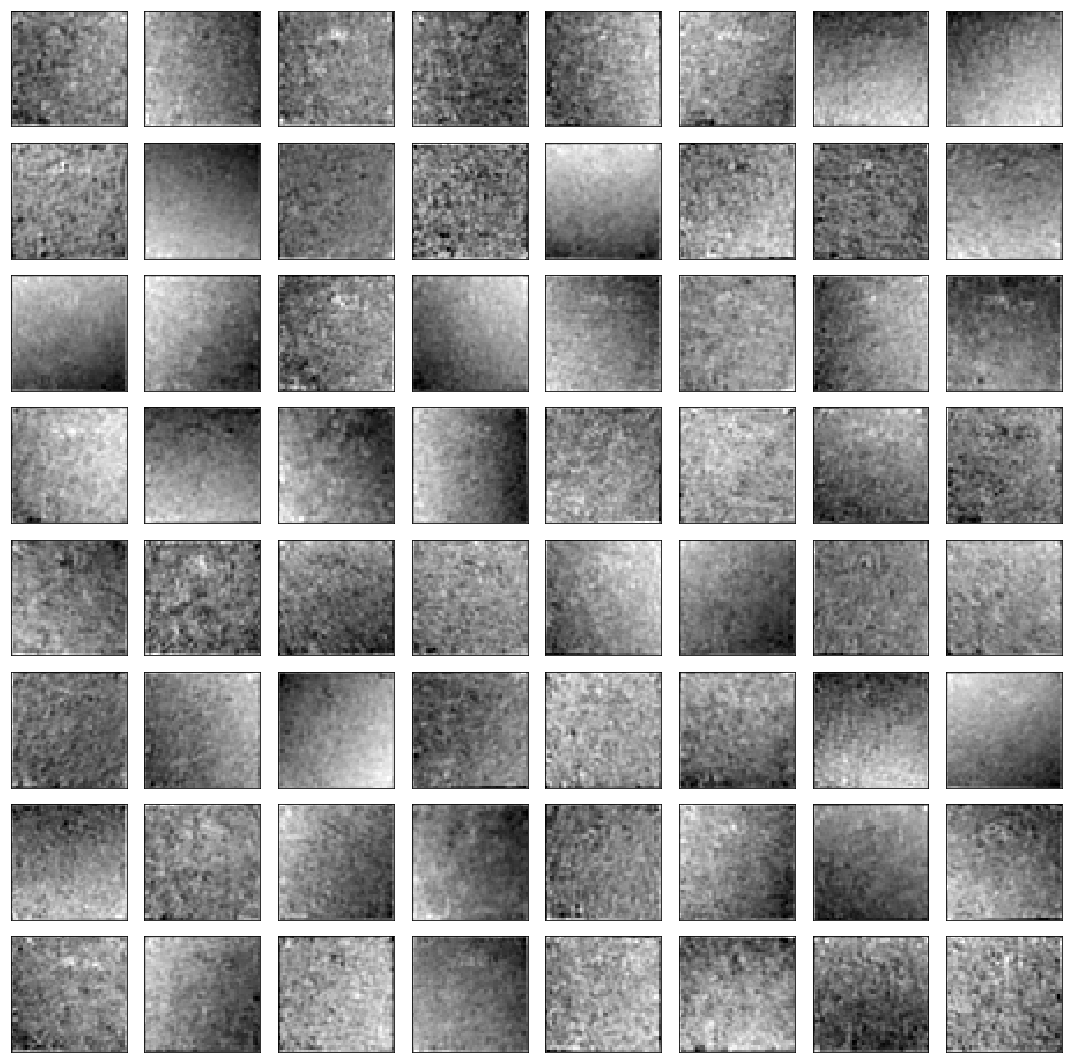

In [33]:
coord_conv_feature_maps = utils_vis.feature_maps(decoder_model, 'coord_conv_9', concat_ex)
utils_vis.plot_feature_maps(coord_conv_feature_maps, 8, 8, figsize=(15,15))

Shape of feature maps: (1, 100, 100, 32)
Number of feature maps in layer:  32


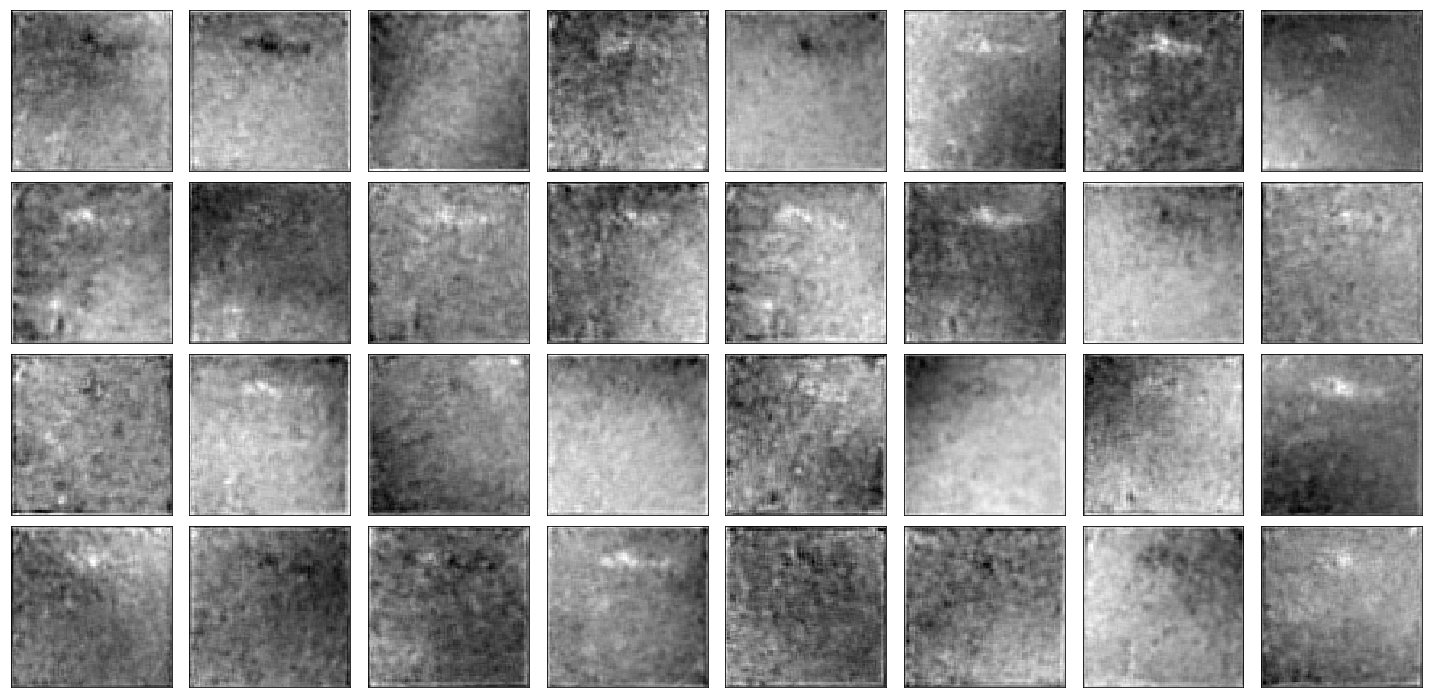

In [34]:
coord_conv_feature_maps = utils_vis.feature_maps(decoder_model, 'conv2d_36', concat_ex)
utils_vis.plot_feature_maps(coord_conv_feature_maps, 4, 8, figsize=(20,10))

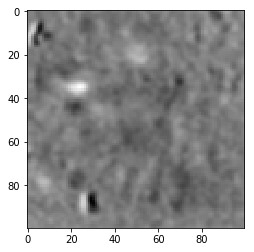

In [35]:
plt.imshow(np.squeeze(input_imgs_npy[-1,5]), cmap = 'gray')

In [36]:
#concat latent space as input
squeeze_coords = np.squeeze(coords_list_npy[-1]) #use the last pos
similarity_score = similarity_list_npy[-1]


concat = tf.stack((squeeze_coords[:,-2], squeeze_coords[:,-1], similarity_score[5]), axis=-1)
concat_ex = concat[np.newaxis,:,:,np.newaxis] #extand axis=0 and axis=-1 for input into model
print(concat_ex.shape)

(1, 200, 3, 1)


Shape of feature maps: (1, 50, 50, 64)
Number of feature maps in layer:  64


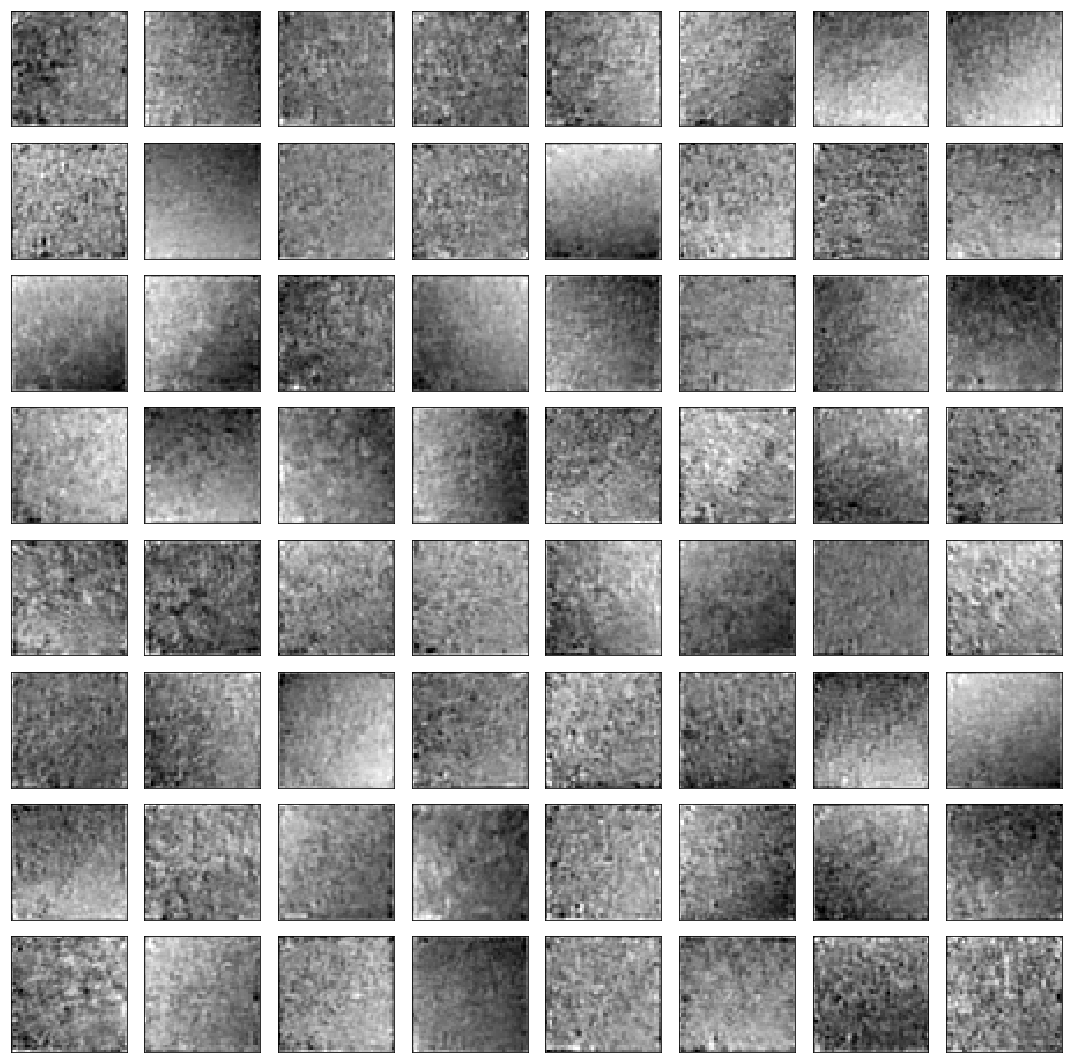

In [37]:
coord_conv_feature_maps = utils_vis.feature_maps(decoder_model, 'coord_conv_9', concat_ex)
utils_vis.plot_feature_maps(coord_conv_feature_maps, 8, 8, figsize=(15,15))

Shape of feature maps: (1, 100, 100, 32)
Number of feature maps in layer:  32


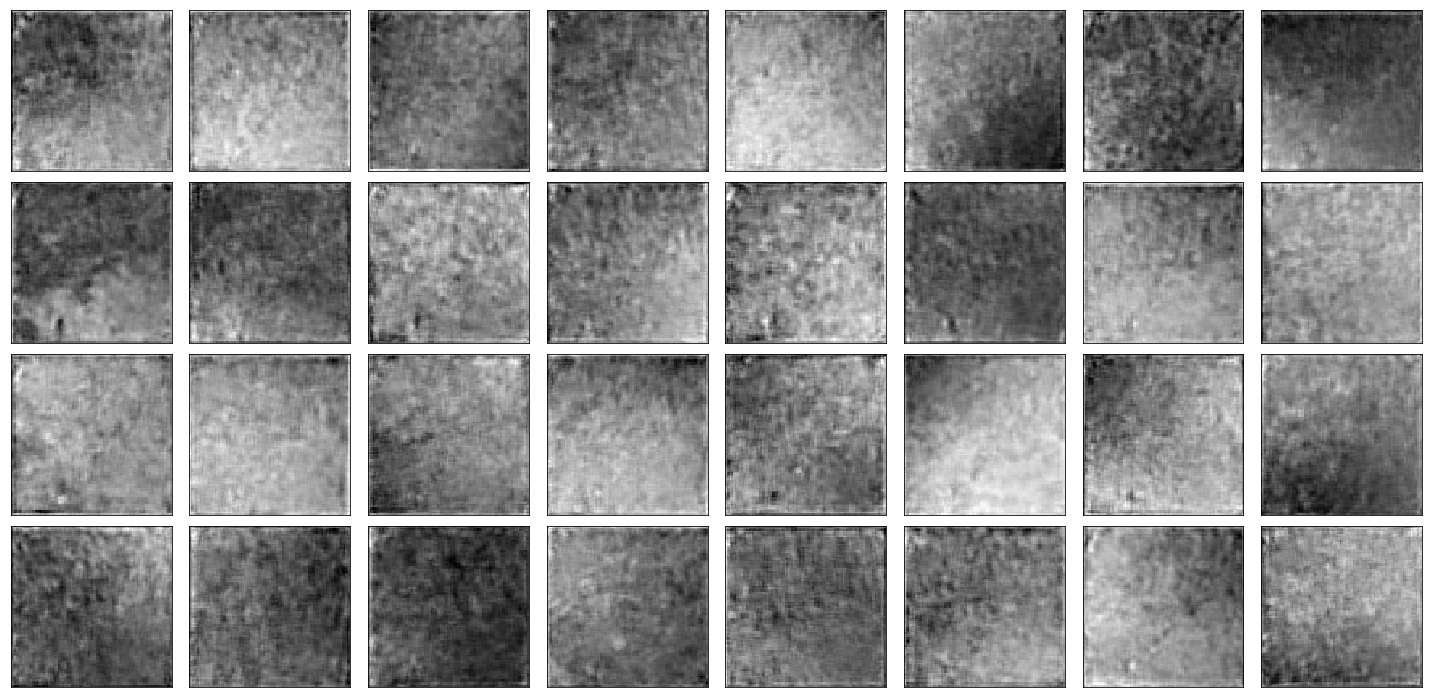

In [38]:
coord_conv_feature_maps = utils_vis.feature_maps(decoder_model, 'conv2d_36', concat_ex)
utils_vis.plot_feature_maps(coord_conv_feature_maps, 4, 8, figsize=(20,10))

---

# Visualization Per-frame

In [39]:
one_hot_imgs_last_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'one_hot_imgs_last_list', ver))
encoder_output_last_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'encoder_output_last_list', ver))
similarity_score_last_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'similarity_score_last_list', ver))
reconstruction_last_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'reconstruction_last_list', ver))

In [40]:

def multi_similarity_frame(one_hot_imgs_last_list_npy, similarity_score_last_list_npy, img_size, batch_size):
    '''
    Multiply similarity scores for every one hot pixel images and aggregate the one hot images into
    single frames
    
    @param one_hot_imgs_last_list_npy: .npy array of one hot images for the last epochs 
    @param similarity_score_last_list_npy: .npy array of similarity score for the last epochs
    @param img_size: image size
    @param batch_size: batch size
    
    return 
    tensor of one hot images multiplied with similarity scores for each images 
    '''
    count = 0
    onehot_list = []
    for one_hot in np.squeeze(one_hot_imgs_last_list_npy):
        if count!=len(similarity_score_last_list_npy): 
            for idx in range(count,count+batch_size): #loop through the similarity score for every batch_size increment
                sum_multi = np.zeros((img_size, img_size))
                for n in range(len(one_hot)): #n_neurons
                    multi = similarity_score_last_list_npy[idx, n]*one_hot[n]
                    sum_multi+=multi #sum all the one hot images
                onehot_list.append(sum_multi)
        count+=batch_size
        tensor = tf.convert_to_tensor(onehot_list, tf.float32)
    
    return tensor

In [41]:
tensor = multi_similarity_frame(one_hot_imgs_last_list_npy, similarity_score_last_list_npy, IMG_SIZE, BATCH_SIZE)

## Maximum Intensity Projection

In [96]:
# plt_captions = ['Original Coordinates', 'Maximum Intensity Projection']
# plt_row = [stack4plot(ori_one_hot_imgs_npy), np.where(np.sum(tensor, axis=0)<0.8, 0, 1.0)]

# plot_comparison(plt_row , plt_captions, n_col=len(plt_row), figsize = (15, 15))

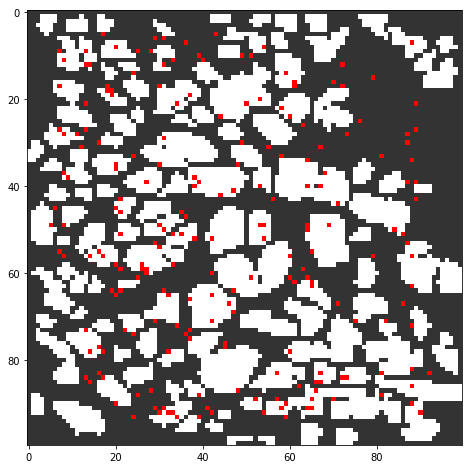

In [42]:
#define color
col = [(0.2, 0.2, 0.2),(1,1,1),(1,0,0)] 
cm = LinearSegmentedColormap.from_list('mylist', col, 3)  
#     #Bins for cmap
bounds=[0,1,5,10]
norm = BoundaryNorm(bounds, cm.N)

plt.figure(figsize=(8,8))
tensor_sum02 = np.where(np.sum(tensor, axis=0)<0.8, 0, 1.0)
roi_frame = overlapMasks02(roi_img, tensor_sum02)
plt.imshow(roi_frame, cmap = cm , norm = norm)
plt.show()

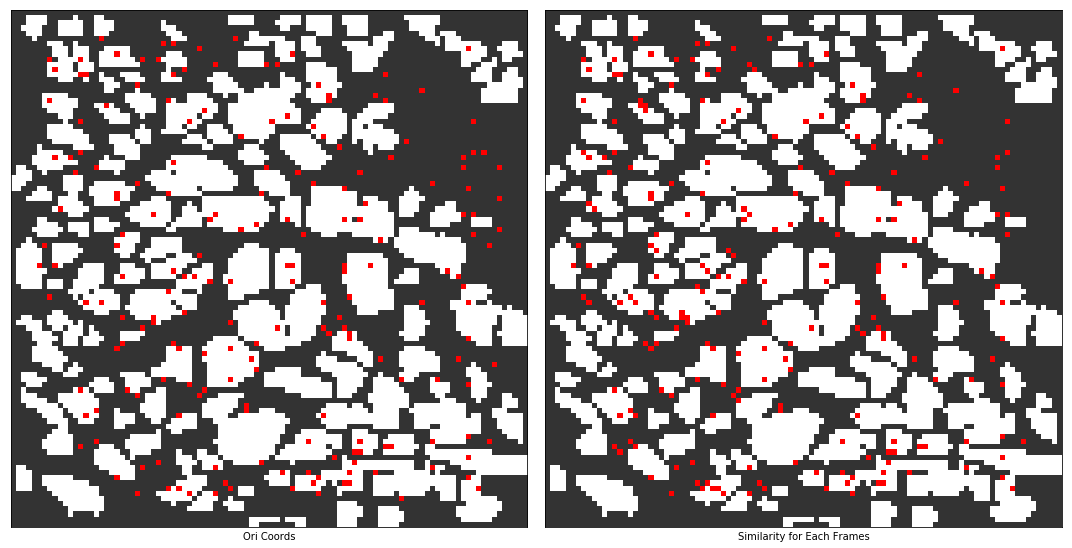

Counts:  213


In [43]:
#overlap mask with original coordinates 
roi_ori_mask = overlapMasks02(roi_img, stack4plot(ori_one_hot_imgs_npy))

captions_05 = ['Ori Coords', 'Similarity for Each Frames']
img_row05 = [roi_ori_mask, roi_frame]
plot_comparison(img_row05, captions_05, n_col=len(img_row05), figsize = (15, 15), cmap = cm, norm = norm)

activations_count = np.count_nonzero(tensor_sum02!=0)
print("Counts: ", activations_count)